## modello Densenet

In [2]:
import os
import pathlib
import zipfile
import tensorflow as tf

In [ ]:
import os
import pathlib
import zipfile
import tensorflow as tf

train_data_dir = pathlib.Path('/kaggle/input/train-set-class/train_set_class')

batch_size = 128
image_size = (224, 224)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

print("Train dataset ready.")

Found 5020 files belonging to 251 classes.
Train dataset ready.


In [4]:
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [5]:
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)

In [6]:
for images, labels in train_ds.take(1):  # Prendi solo il primo batch
    print("Batch shape (immagini):", images.shape)
    print("Batch shape (etichette):", labels.shape)

Batch shape (immagini): (128, 224, 224, 3)
Batch shape (etichette): (128, 251)


In [ ]:

unlabeled_data_dir = pathlib.Path('/kaggle/input/train-set-unlabeled/train_set_unlabeled')

batch_size = 128
image_size = (224, 224)

unlabeled_ds = tf.keras.preprocessing.image_dataset_from_directory(
    unlabeled_data_dir,
    labels=None,  # Nessuna etichetta, dato che è unlabeled
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False,  # Di solito non mescoliamo dati non etichettati (opzionale)
    seed=42
)
def normalize_image2(image):
    image = tf.cast(image, tf.float32) / 255.0
    return image

unlabeled_ds = unlabeled_ds.map(normalize_image2, num_parallel_calls=tf.data.AUTOTUNE)
print("Unlabeled dataset ready.")

In [ ]:
val_data_dir = pathlib.Path('/kaggle/input/val-set-class/val_set_class')

batch_size = 128
image_size = (224, 224)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    seed=42
)
val_ds = val_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
print("Val dataset ready.")

Found 11994 files belonging to 251 classes.
Val dataset ready.


In [11]:
for images, labels in val_ds.take(1):  # Prendi solo il primo batch
    print("Batch shape (immagini):", images.shape)
    print("Batch shape (etichette):", labels.shape)

Batch shape (immagini): (128, 224, 224, 3)
Batch shape (etichette): (128, 251)


carichiamo il degraded test set

In [ ]:
test_data_dir = pathlib.Path('/kaggle/input/val-set-degraded-class/val_set_degraded_class')

batch_size = 128
image_size = (224, 224)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    seed=42
)
test_ds = test_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
print("Val dataset ready.")

Found 11994 files belonging to 251 classes.
Val dataset ready.


In [13]:
for images, labels in test_ds.take(1):  # Prendi solo il primo batch
    print("Batch shape (immagini):", images.shape)
    print("Batch shape (etichette):", labels.shape)

Batch shape (immagini): (128, 224, 224, 3)
Batch shape (etichette): (128, 251)


## Carichiamo e prepariamo il modello

📌 Struttura:
- Caricamento DenseNet201 pre-addestrato
- Congelamento pesi del modello base
- Aggiunta di un nuovo Fully Connected Network: 512 → 256 → 128 neuroni, ciascuno con: ReLU
- Batch Normalization
- Dropout più elevato (50%, 40%)

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
import tensorflow as tf

def custom_layer_wrapper(layer_class):
    def wrapper(*args, **kwargs):
        if 'name' in kwargs:
            kwargs['name'] = kwargs['name'].replace('/', '_')  # Sostituisce "/" con "_"
        return layer_class(*args, **kwargs)
    return wrapper

custom_conv2d = custom_layer_wrapper(Conv2D)
custom_batch_norm = custom_layer_wrapper(BatchNormalization)
custom_activation = custom_layer_wrapper(Activation)

model_path = '/kaggle/input/resnet_kaggle1/other/default/1/RESNET_Kaggle.hdf5'

resnet_kaggle_model = tf.keras.models.load_model(
    model_path,
    custom_objects={
        'Conv2D': custom_conv2d,
        'BatchNormalization': custom_batch_norm,
        'Activation': custom_activation
    }
)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Resizing, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
# === 1. Definiamo il nuovo input layer per immagini 224×224×3 ===
input_layer = Input(shape=(224, 224, 3))

# === 2. Congeliamo i pesi del modello preaddestrato ===
resnet_kaggle_model.trainable = False

# === 3. Creiamo un modello intermedio utilizzando l'output del layer globale di pooling ===
output_layer = resnet_kaggle_model.get_layer("global_average_pooling2d").output
intermediate_model = Model(inputs=resnet_kaggle_model.input, outputs=output_layer)

# === 4. Applichiamo l'input al modello intermedio ===
x = intermediate_model(input_layer)

# === 5. Aggiungiamo i layer fully connected ===
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Layer finale con 251 classi
output = Dense(251, activation='softmax')(x)

# === 6. Compilazione del modello ===
final_model = Model(inputs=input_layer, outputs=output)
optimizer = Adam(learning_rate=0.001)
final_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

final_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional (Functional)              │ (None, 1920)                │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         983,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 251)                 │          32,379 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,505,723 (74.41 MB)

 Trainable params: 1,181,947 (4.51 MB)

 Non-trainable params: 18,323,776 (69.90 MB)

In [15]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
# === 8. Definizione dei callback ===
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# === 9. Addestramento del modello con callback ===
history1 = final_model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    verbose=1,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.0089 - loss: 5.8445 - val_accuracy: 0.0612 - val_loss: 5.1642 - learning_rate: 0.0010
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 779ms/step - accuracy: 0.0793 - loss: 4.7857 - val_accuracy: 0.3407 - val_loss: 4.4743 - learning_rate: 0.0010
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 777ms/step - accuracy: 0.2351 - loss: 4.0409 - val_accuracy: 0.4845 - val_loss: 3.6577 - learning_rate: 0.0010
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 779ms/step - accuracy: 0.3740 - loss: 3.4219 - val_accuracy: 0.5295 - val_loss: 2.8926 - learning_rate: 0.0010
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 779ms/step - accuracy: 0.4635 - loss: 2.9230 - val_accuracy: 0.5577 - val_loss: 2.3879 - learning_rate: 0.0010
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 777ms/step - accuracy: 0.5304 - loss: 2.5240 - val_accuracy: 0.5747 - val_loss: 2.1503 - learning_rate: 0.0010
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 778ms/step - accuracy: 0.5777 - loss: 2.21

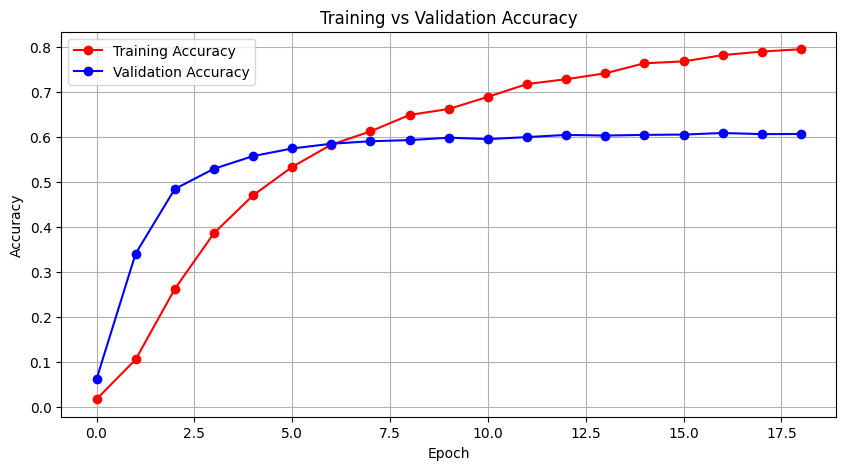

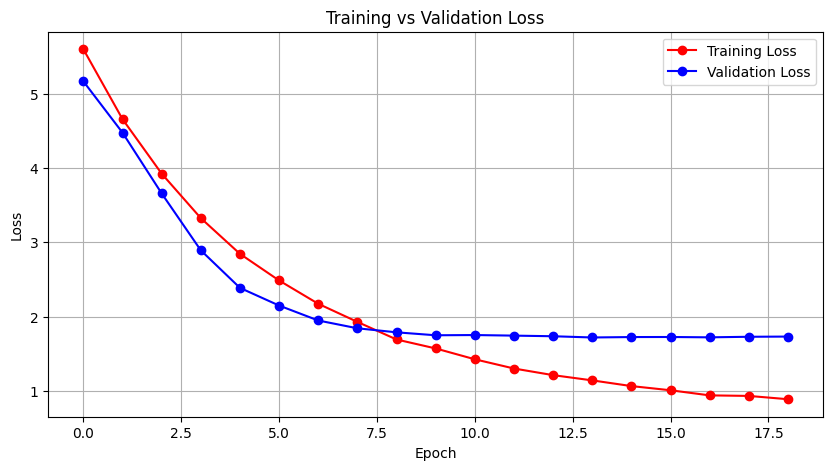

In [ ]:
import matplotlib.pyplot as plt

accuracy = history1.history['accuracy']
loss = history1.history['loss']

plt.figure(figsize=(10, 5))
plt.plot(accuracy, label='Training Accuracy', marker='o', color='red')
plt.plot(history1.history['val_accuracy'], marker='o', color='blue', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss', marker='o', color='red')
plt.plot(history1.history['val_loss'], marker='o', color='blue', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Ottenere le predizioni
predictions = final_model.predict(val_ds)

# 2. Convertire le predizioni in classi (indice della classe con probabilità massima)
predicted_classes = np.argmax(predictions, axis=1)

# 3. Estrarre le label reali (da val_ds)
true_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in val_ds])

# 4. Calcolare l'accuracy
accuracy = accuracy_score(true_labels, predicted_classes)

print(f'Validation Accuracy: {accuracy:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 47s 363ms/step
Validation Accuracy: 0.6035


In [18]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Ottenere le predizioni
predictions = final_model.predict(test_ds)

# 2. Convertire le predizioni in classi (indice della classe con probabilità massima)
predicted_classes = np.argmax(predictions, axis=1)

# 3. Estrarre le label reali (da val_ds)
true_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in val_ds])

# 4. Calcolare l'accuracy
accuracy = accuracy_score(true_labels, predicted_classes)

print(f'Test Accuracy: {accuracy:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 278ms/step
Test Accuracy: 0.4217


## Ora togliamo le immagini outlier e rialleniamo modello, per poi fare image augmentation

In [2]:
import os
import pathlib
import zipfile
import tensorflow as tf
import pandas as pd
import numpy as np

In [ ]:
train_data_dir = pathlib.Path('/kaggle/input/clean-train-no-outliers')

# Creazione del dataset di addestramento
batch_size = 128
image_size = (224, 224)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=42
)
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
print("Train dataset ready.")

Found 4883 files belonging to 251 classes.
Train dataset ready.


In [ ]:
unlabeled_data_dir = pathlib.Path('/kaggle/input/train-set-unlabeled/train_set_unlabeled')

# Caricamento del dataset non etichettato
batch_size = 128
image_size = (224, 224)

unlabeled_ds = tf.keras.preprocessing.image_dataset_from_directory(
    unlabeled_data_dir,
    labels=None,  # Nessuna etichetta, dato che è unlabeled
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False,  # Di solito non mescoliamo dati non etichettati (opzionale)
    seed=42
)
def normalize_image2(image):
    image = tf.cast(image, tf.float32) / 255.0
    return image

unlabeled_ds = unlabeled_ds.map(normalize_image2, num_parallel_calls=tf.data.AUTOTUNE)
print("Unlabeled dataset ready.")

Found 95194 files.
Unlabeled dataset ready.


In [3]:
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [ ]:
val_data_dir = pathlib.Path('/kaggle/input/val-set-class/val_set_class')

batch_size = 128
image_size = (224, 224)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    seed=42
)
val_ds = val_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
print("Val dataset ready.")

Found 11994 files belonging to 251 classes.
Val dataset ready.


(per 'test', intendiamo il validation degradato)

In [ ]:
test_data_dir = pathlib.Path('/kaggle/input/val-set-degraded-class/val_set_degraded_class')

batch_size = 128
image_size = (224, 224)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    seed=42
)
test_ds = test_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
print("Val dataset ready.")

Found 11994 files belonging to 251 classes.
Val dataset ready.


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation

def custom_layer_wrapper(layer_class):
    def wrapper(*args, **kwargs):
        if 'name' in kwargs:
            kwargs['name'] = kwargs['name'].replace('/', '_')  # Sostituisce "/" con "_"
        return layer_class(*args, **kwargs)
    return wrapper

custom_conv2d = custom_layer_wrapper(Conv2D)
custom_batch_norm = custom_layer_wrapper(BatchNormalization)
custom_activation = custom_layer_wrapper(Activation)

model_path = '/kaggle/input/resnet_kaggle1/other/default/1/RESNET_Kaggle.hdf5'

resnet_kaggle_model = tf.keras.models.load_model(
    model_path,
    custom_objects={
        'Conv2D': custom_conv2d,
        'BatchNormalization': custom_batch_norm,
        'Activation': custom_activation
    }
)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Resizing, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
# === 1. Definiamo il nuovo input layer per immagini 224×224×3 ===
input_layer = Input(shape=(224, 224, 3))

# === 2. Congeliamo i pesi del modello preaddestrato ===
resnet_kaggle_model.trainable = False

# === 3. Creiamo un modello intermedio utilizzando l'output del layer globale di pooling ===
output_layer = resnet_kaggle_model.get_layer("global_average_pooling2d").output
intermediate_model = Model(inputs=resnet_kaggle_model.input, outputs=output_layer)

# === 4. Applichiamo l'input al modello intermedio ===
x = intermediate_model(input_layer)

# === 5. Aggiungiiamo i layer fully connected ===
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Layer finale con 251 classi
output = Dense(251, activation='softmax')(x)

# === 6. Compilazione del modello ===
final_model = Model(inputs=input_layer, outputs=output)
optimizer = Adam(learning_rate=0.001)
final_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

final_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional (Functional)              │ (None, 1920)                │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         983,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 251)                 │          32,379 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,505,723 (74.41 MB)

 Trainable params: 1,181,947 (4.51 MB)

 Non-trainable params: 18,323,776 (69.90 MB)

In [9]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
# === 8. Definizione dei callback ===
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=11, restore_best_weights=True)

# === 9. Addestramento del modello con callback ===
history2 = final_model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    verbose=1,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.0096 - loss: 5.8044 - val_accuracy: 0.0655 - val_loss: 5.1375 - learning_rate: 0.0010
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 794ms/step - accuracy: 0.0877 - loss: 4.8138 - val_accuracy: 0.3164 - val_loss: 4.4515 - learning_rate: 0.0010
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 793ms/step - accuracy: 0.2283 - loss: 4.0599 - val_accuracy: 0.4635 - val_loss: 3.6249 - learning_rate: 0.0010
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 793ms/step - accuracy: 0.3594 - loss: 3.4864 - val_accuracy: 0.5200 - val_loss: 2.9150 - learning_rate: 0.0010
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 795ms/step - accuracy: 0.4628 - loss: 2.9561 - val_accuracy: 0.5503 - val_loss: 2.4350 - learning_rate: 0.0010
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 793ms/step - accuracy: 0.5186 - loss: 2.5749 - val_accuracy: 0.5677 - val_loss: 2.1585 - learning_rate: 0.0010
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 793ms/step - accuracy: 0.5715 - loss: 2.21

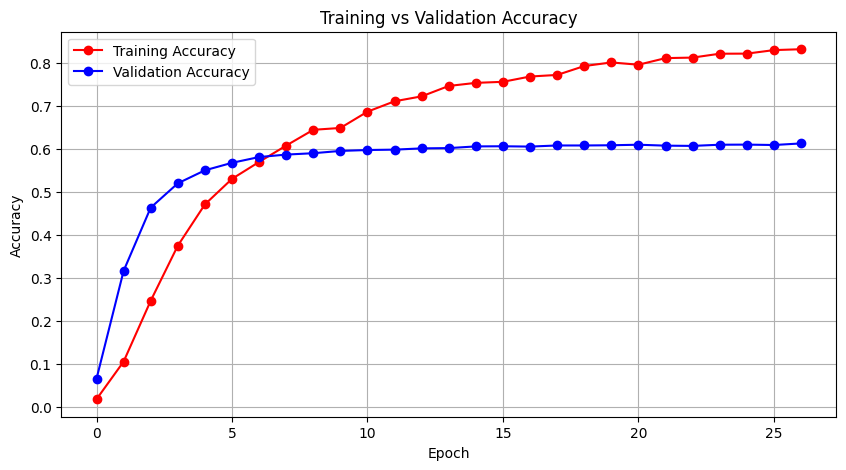

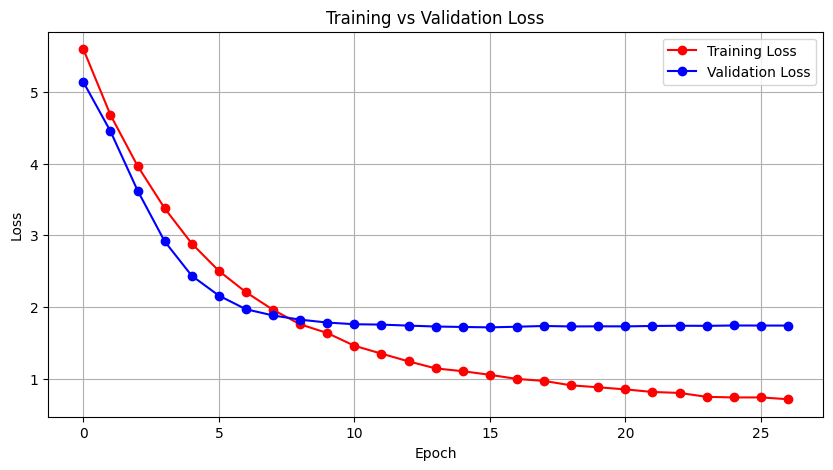

In [ ]:
import matplotlib.pyplot as plt
accuracy = history2.history['accuracy']
loss = history2.history['loss']

plt.figure(figsize=(10, 5))
plt.plot(accuracy, label='Training Accuracy', marker='o', color='red')
plt.plot(history2.history['val_accuracy'], marker='o', color='blue', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss', marker='o', color='red')
plt.plot(history2.history['val_loss'], marker='o', color='blue', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Ottenere le predizioni
predictions = final_model.predict(val_ds)

# 2. Convertire le predizioni in classi (indice della classe con probabilità massima)
predicted_classes = np.argmax(predictions, axis=1)

# 3. Estrarre le label reali (da val_ds)
true_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in val_ds])

# 4. Calcolare l'accuracy
accuracy = accuracy_score(true_labels, predicted_classes)

print(f'Validation Accuracy: {accuracy:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 49s 382ms/step
Validation Accuracy: 0.6062


In [12]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Ottenere le predizioni
predictions = final_model.predict(test_ds)

# 2. Convertire le predizioni in classi (indice della classe con probabilità massima)
predicted_classes = np.argmax(predictions, axis=1)

# 3. Estrarre le label reali (da val_ds)
true_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in val_ds])

# 4. Calcolare l'accuracy
accuracy = accuracy_score(true_labels, predicted_classes)

print(f'Test Accuracy: {accuracy:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 33s 351ms/step
Test Accuracy: 0.4218


## Vediamo la confidenza con cui classifica

prima sul validation per farci un idea, poi sull'unlabeled per andare ad aggiungere nuove immagini di training

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
from sklearn.metrics import accuracy_score

# 1. Ottenere le predizioni
predictions = final_model.predict(val_ds)

# 2. Calcola la classe predetta e la confidenza (max softmax)
predicted_classes = np.argmax(predictions, axis=1)
confidences = np.max(predictions, axis=1)  # Confidenza basata su max softmax

# 3. Calcola l'entropia per ogni immagine
entropies = entropy(predictions.T)  # Entropia per ogni immagine

# 4. Estrarre le label reali (da val_ds)
true_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in val_ds])

# 5. Estrarre i nomi dei file delle immagini
if hasattr(val_ds, 'file_paths'):
    sampled_images = val_ds.file_paths  # Se il dataset ha file_paths
else:
    sampled_images = [f"image_{i}.jpg" for i in range(len(true_labels))]  # Fallback generico

# 6. Calcolare l'accuracy
accuracy = accuracy_score(true_labels, predicted_classes)
print(f'Validation Accuracy: {accuracy:.4f}')

results_df = pd.DataFrame({
    'Percorso Immagine': sampled_images,  # Percorsi delle immagini
    'Classe Predetta': predicted_classes,
    'Label Reale': true_labels,
    'Confidenza (Max Softmax)': confidences,
    'Entropia (Incertezza)': entropies
})

display(results_df)

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 223ms/step
Validation Accuracy: 0.6062


,Percorso Immagine,Classe Predetta,Label Reale,Confidenza (Max Softmax),Entropia (Incertezza)
0,image_0.jpg,0,0,0.184471,4.201436
1,image_1.jpg,0,0,0.997536,0.026471
2,image_2.jpg,0,0,0.989397,0.095540
3,image_3.jpg,0,0,0.991426,0.082042
4,image_4.jpg,208,0,0.208979,3.951222
...,...,...,...,...,...
11989,image_11989.jpg,250,250,0.566552,2.430770
11990,image_11990.jpg,250,250,0.920358,0.589547
11991,image_11991.jpg,227,250,0.149152,4.282969
11992,image_11992.jpg,151,250,0.586514,2.277477


In [14]:
df_esatti = results_df[results_df['Classe Predetta'] == results_df['Label Reale']]
df_esatti.head(3)

,Percorso Immagine,Classe Predetta,Label Reale,Confidenza (Max Softmax),Entropia (Incertezza)
0,image_0.jpg,0,0,0.184471,4.201436
1,image_1.jpg,0,0,0.997536,0.026471
2,image_2.jpg,0,0,0.989397,0.095540


In [15]:
df_sbagliati= results_df[results_df['Classe Predetta'] != results_df['Label Reale']]
df_sbagliati.head(3)

,Percorso Immagine,Classe Predetta,Label Reale,Confidenza (Max Softmax),Entropia (Incertezza)
4,image_4.jpg,208,0,0.208979,3.951222
8,image_8.jpg,63,0,0.227326,2.965867
14,image_14.jpg,212,0,0.127736,4.109645


In [16]:
print(df_esatti.shape)
print(df_sbagliati.shape)

(7271, 5)
(4723, 5)


In [17]:
df_esatti['Confidenza (Max Softmax)'].describe()

count    7271.000000
mean        0.776419
std         0.243496
min         0.057775
25%         0.617425
50%         0.886752
75%         0.977702
max         0.999956
Name: Confidenza (Max Softmax), dtype: float64

In [18]:
df_sbagliati['Confidenza (Max Softmax)'].describe()

count    4723.000000
mean        0.433612
std         0.246755
min         0.037436
25%         0.227257
50%         0.394487
75%         0.602214
max         0.998115
Name: Confidenza (Max Softmax), dtype: float64

In [19]:
df_esatti['Entropia (Incertezza)'].describe()

count    7271.000000
mean        0.988170
std         1.028123
min         0.000634
25%         0.164011
50%         0.612864
75%         1.508039
max         4.700453
Name: Entropia (Incertezza), dtype: float64

In [20]:
df_sbagliati['Entropia (Incertezza)'].describe()

count    4723.000000
mean        2.360182
std         1.166131
min         0.019989
25%         1.399919
50%         2.366731
75%         3.357471
max         4.971456
Name: Entropia (Incertezza), dtype: float64

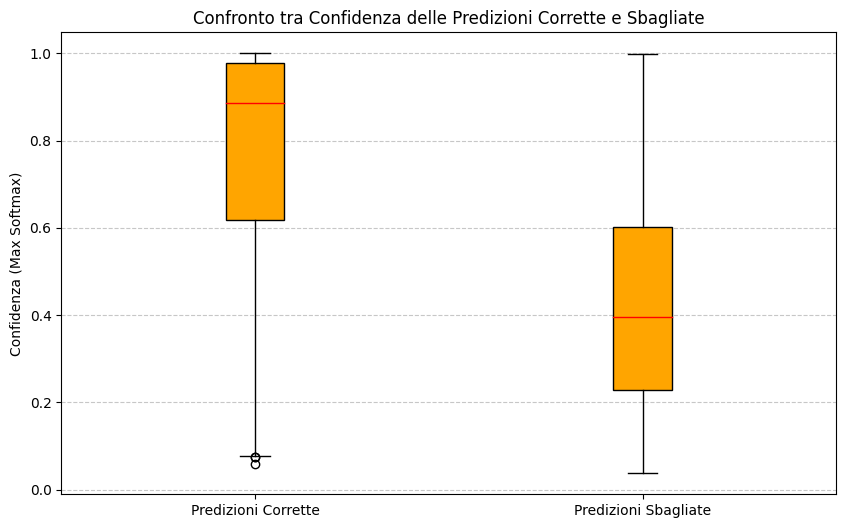

In [ ]:
# Boxplot dei due gruppi affiancati
plt.figure(figsize=(10, 6))
plt.boxplot(
    [df_esatti['Confidenza (Max Softmax)'], df_sbagliati['Confidenza (Max Softmax)']], 
    labels=['Predizioni Corrette', 'Predizioni Sbagliate'],
    patch_artist=True,
    boxprops=dict(facecolor='orange', color='black'),  # Colore del box
    medianprops=dict(color='red')  # Colore della mediana
)

plt.title('Confronto tra Confidenza delle Predizioni Corrette e Sbagliate')
plt.ylabel('Confidenza (Max Softmax)')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Aggiunge la griglia solo sull'asse y
plt.show()

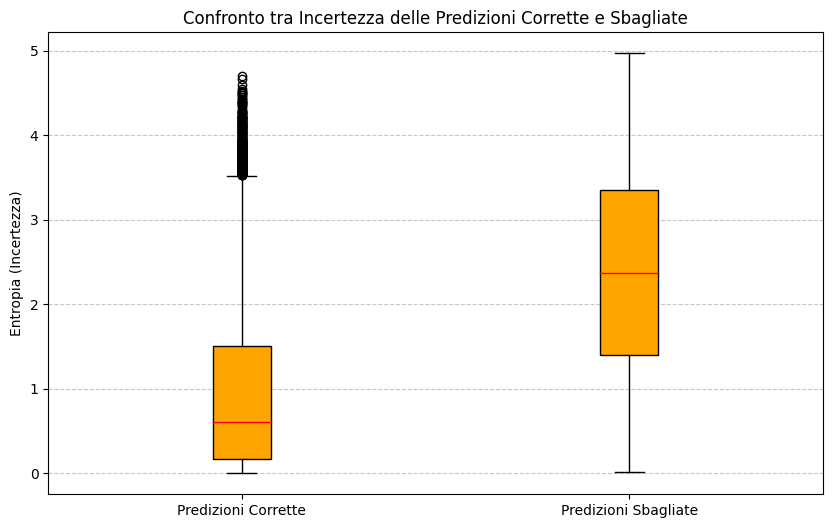

In [ ]:
# Boxplot dei due gruppi affiancati
plt.figure(figsize=(10, 6))
plt.boxplot(
    [df_esatti['Entropia (Incertezza)'], df_sbagliati['Entropia (Incertezza)']], 
    labels=['Predizioni Corrette', 'Predizioni Sbagliate'],
    patch_artist=True,
    boxprops=dict(facecolor='orange', color='black'),  # Colore del box
    medianprops=dict(color='red')  # Colore della mediana
)

plt.title('Confronto tra Incertezza delle Predizioni Corrette e Sbagliate')
plt.ylabel('Entropia (Incertezza)')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Aggiunge la griglia solo sull'asse y
plt.show()

## First Image Augmentation

Ora facciamo il predict sull'unalebed e aggiungiamo le immagini

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
from sklearn.metrics import accuracy_score

# 1. Ottenere le predizioni
predictions = final_model.predict(unlabeled_ds)

# 2. Controllo della dimensione delle predizioni
num_predictions = predictions.shape[0]
print(f"Numero di predizioni: {num_predictions}")

# 3. Calcola la classe predetta e la confidenza (max softmax)
predicted_classes = np.argmax(predictions, axis=1)
confidences = np.max(predictions, axis=1)  # Confidenza basata su max softmax

# 4. Controllo che lunghezza delle predizioni sia corretta
assert len(predicted_classes) == num_predictions, "Errore: predicted_classes ha lunghezza errata"
assert len(confidences) == num_predictions, "Errore: confidences ha lunghezza errata"

# 5. Calcoliamo l'entropia per ogni immagine
entropies = entropy(predictions.T, axis=0)  # Assicura che l'entropia sia calcolata correttamente

# 6. Controllo dimensione entropia
assert len(entropies) == num_predictions, "Errore: l'entropia non ha la stessa lunghezza delle predizioni"

# 7. Estrarre i percorsi delle immagini
image_paths = []

# Verifica se il dataset ha batch
for i, img_batch in enumerate(unlabeled_ds.unbatch()):
    if isinstance(img_batch, tuple):
        img = img_batch[0]  # Se il dataset ha tuple (img, label), prendiamo solo l'immagine
    else:
        img = img_batch  # Se il dataset ha solo immagini
    formatted_num = str(i).zfill(6)
    image_paths.append(f"train_{formatted_num}.jpg")  # Placeholder per i nomi delle immagini

# Controllo che il numero di immagini corrisponda al numero di predizioni
assert len(image_paths) == num_predictions, f"Errore: {len(image_paths)} immagini vs {num_predictions} predizioni"

results_df = pd.DataFrame({
    'Percorso Immagine': image_paths,
    'Classe Predetta': predicted_classes,
    'Confidenza (Max Softmax)': confidences,
    'Entropia (Incertezza)': entropies
})

# 9. Mostra il DataFrame
display(results_df)

744/744 ━━━━━━━━━━━━━━━━━━━━ 235s 298ms/step
Numero di predizioni: 95194


,Percorso Immagine,Classe Predetta,Confidenza (Max Softmax),Entropia (Incertezza)
0,train_000000.jpg,245,0.985803,0.129342
1,train_000001.jpg,245,0.999365,0.007755
2,train_000002.jpg,245,0.914168,0.610029
3,train_000003.jpg,245,0.949565,0.411032
4,train_000004.jpg,245,0.626074,2.312660
...,...,...,...,...
95189,train_095189.jpg,28,0.491156,2.428349
95190,train_095190.jpg,28,0.783008,0.872468
95191,train_095191.jpg,28,0.891667,0.522123
95192,train_095192.jpg,28,0.959270,0.223085


In [ ]:
results_df = results_df.sort_values(by='Entropia (Incertezza)', ascending=True)
dataset_per_immagini = results_df[results_df['Entropia (Incertezza)'] <= 0.03]
dataset_per_immagini = dataset_per_immagini[dataset_per_immagini['Confidenza (Max Softmax)'] >= 0.98]
dataset_per_immagini = dataset_per_immagini[['Percorso Immagine','Classe Predetta']]
print(dataset_per_immagini.shape)
dataset_per_immagini.head(3)

(3243, 2)


,Percorso Immagine,Classe Predetta
27167,train_027167.jpg,232
27124,train_027124.jpg,232
80439,train_080439.jpg,7


In [25]:
dataset_per_immagini.to_csv("/kaggle/working/df_per_immagini1.csv", index=False)

In [ ]:
import tensorflow as tf
import pathlib
import numpy as np

unlabeled_data_dir = pathlib.Path('/kaggle/input/train-set-unlabeled/train_set_unlabeled/-1')
df= dataset_per_immagini
# Creiamo un dizionario {nome immagine: etichetta} per velocizzare l'accesso
df['Percorso Immagine'] = df['Percorso Immagine'].apply(lambda x: x.split('/')[-1])
df['Percorso Immagine'] = df['Percorso Immagine'].apply(lambda x: x.split('_')[0] + '_' + x.split('_')[1].zfill(6))

image_dict = dict(zip(df['Percorso Immagine'], df['Classe Predetta']))

image_paths = sorted(unlabeled_data_dir.glob('*.jpg'))

to_add_images = [str(image_path) for image_path in image_paths if image_path.name in image_dict]

# Associa ogni immagine alla sua etichetta
to_add_labels = [image_dict[image_path.name] for image_path in image_paths if image_path.name in image_dict]

# Converti le etichette in interi e poi in one-hot
num_classes =251 # Numero di classi uniche
to_add_labels = np.array(to_add_labels, dtype=np.int32)  # Converti in interi
to_add_labels_one_hot = tf.one_hot(to_add_labels, num_classes)  # One-hot encoding

# Funzione per leggere e preprocessare le immagini
def process_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decodifica come immagine RGB
    image = tf.image.resize(image, (224, 224))  # Ridimensiona
    image = tf.cast(image, tf.float32) / 255.0  # Normalizzazione tra 0 e 1
    return image

image_ds = tf.data.Dataset.from_tensor_slices(to_add_images)
image_ds = image_ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

label_ds = tf.data.Dataset.from_tensor_slices(to_add_labels_one_hot)

# Unisci immagini ed etichette in un dataset
image_ds = tf.data.Dataset.zip((image_ds, label_ds))
image_ds = image_ds.batch(128).prefetch(tf.data.AUTOTUNE)

print(f"✅ image_ds creato con {len(to_add_images)} immagini.")

# Caricamento del dataset etichettato (train_ds)
train_data_dir = pathlib.Path('/kaggle/input/clean-train-no-outliers')

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=128,
    shuffle=True,
    seed=42
).prefetch(tf.data.AUTOTUNE)

print(f"✅ train_ds caricato.")

# Controlliamo che le forme di `image_ds` e `train_ds` siano compatibili prima della concatenazione
for image, label in train_ds.take(1):
    print(f"train_ds shape: {image.shape}, {label.shape}")

for image, label in image_ds.take(1):
    print(f"image_ds shape: {image.shape}, {label.shape}")

✅ image_ds creato con 4705 immagini.
Found 4883 files belonging to 251 classes.
✅ train_ds caricato.
train_ds shape: (128, 224, 224, 3), (128, 251)
image_ds shape: (128, 224, 224, 3), (128, 251)


In [ ]:
image_ds_dict = {pathlib.Path(img_path).name: label.numpy().argmax() 
                 for img_path, label in zip(to_add_images, to_add_labels_one_hot)}

mismatch = {img_name: (df_label, image_ds_dict[img_name]) 
            for img_name, df_label in image_dict.items() 
            if img_name in image_ds_dict and df_label != image_ds_dict[img_name]}

if not mismatch:
    print("✅ Tutte le etichette delle immagini corrispondono tra df e image_ds")
else:
    print("⚠️ Alcune etichette non corrispondono tra df e image_ds")
    for img, (df_label, ds_label) in mismatch.items():
        print(f"  - {img}: df = {df_label}, image_ds = {ds_label}")

✅ Tutte le etichette delle immagini corrispondono tra df e image_ds


In [ ]:
# Combiniamo i dataset
train_ds = train_ds.concatenate(image_ds)

# Contiamo il numero totale di immagini
num_images_in_train_ds = sum(1 for _ in train_ds)
print(f"✅ Numero totale di immagini in train_ds dopo concatenamento: {num_images_in_train_ds}")

✅ Numero totale di immagini in train_ds dopo concatenamento: 76


## Secondo image augmentation

In [ ]:
train_data_dir = pathlib.Path('/kaggle/input/train-set-augmented1/train_set_augmented1')

batch_size = 128
image_size = (224, 224)

train_ds2 = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=42
)
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds2 = train_ds2.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds2 = train_ds2.prefetch(buffer_size=tf.data.AUTOTUNE)
print("Train dataset ready.")

Found 7923 files belonging to 251 classes.
Train dataset ready.


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation

def custom_layer_wrapper(layer_class):
    def wrapper(*args, **kwargs):
        if 'name' in kwargs:
            kwargs['name'] = kwargs['name'].replace('/', '_')  # Sostituisce "/" con "_"
        return layer_class(*args, **kwargs)
    return wrapper

custom_conv2d = custom_layer_wrapper(Conv2D)
custom_batch_norm = custom_layer_wrapper(BatchNormalization)
custom_activation = custom_layer_wrapper(Activation)

model_path = '/kaggle/input/resnet_kaggle1/other/default/1/RESNET_Kaggle.hdf5'

resnet_kaggle_model = tf.keras.models.load_model(
    model_path,
    custom_objects={
        'Conv2D': custom_conv2d,
        'BatchNormalization': custom_batch_norm,
        'Activation': custom_activation
    }
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Resizing, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

input_layer = Input(shape=(224, 224, 3))

resnet_kaggle_model.trainable = False

output_layer = resnet_kaggle_model.get_layer("global_average_pooling2d").output
intermediate_model = Model(inputs=resnet_kaggle_model.input, outputs=output_laye
x = intermediate_model(input_layer)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

output = Dense(251, activation='softmax')(x)

final_model = Model(inputs=input_layer, outputs=output)
optimizer = Adam(learning_rate=0.001)
final_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

final_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_6 (Functional)            │ (None, 1920)                │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │         983,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 251)                 │          32,379 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,505,723 (74.41 MB)

 Trainable params: 1,181,947 (4.51 MB)

 Non-trainable params: 18,323,776 (69.90 MB)

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=11, restore_best_weights=True)

history3 = final_model.fit(
    train_ds2,
    epochs=50,
    validation_data=val_ds,
    verbose=1,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.0183 - loss: 5.7251 - val_accuracy: 0.0660 - val_loss: 5.1384 - learning_rate: 0.0010
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 594ms/step - accuracy: 0.1532 - loss: 4.5780 - val_accuracy: 0.1650 - val_loss: 4.4201 - learning_rate: 0.0010
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 595ms/step - accuracy: 0.2543 - loss: 3.9179 - val_accuracy: 0.2552 - val_loss: 3.6629 - learning_rate: 0.0010
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 595ms/step - accuracy: 0.3087 - loss: 3.4413 - val_accuracy: 0.3147 - val_loss: 3.1012 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 596ms/step - accuracy: 0.3601 - loss: 3.0482 - val_accuracy: 0.3684 - val_loss: 2.7564 - learning_rate: 0.0010
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 595ms/step - accuracy: 0.3995 - loss: 2.7461 - val_accuracy: 0.3917 - val_loss: 2.5122 - learning_rate: 0.0010
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 596ms/step - accuracy: 0.4250 - loss: 2.50

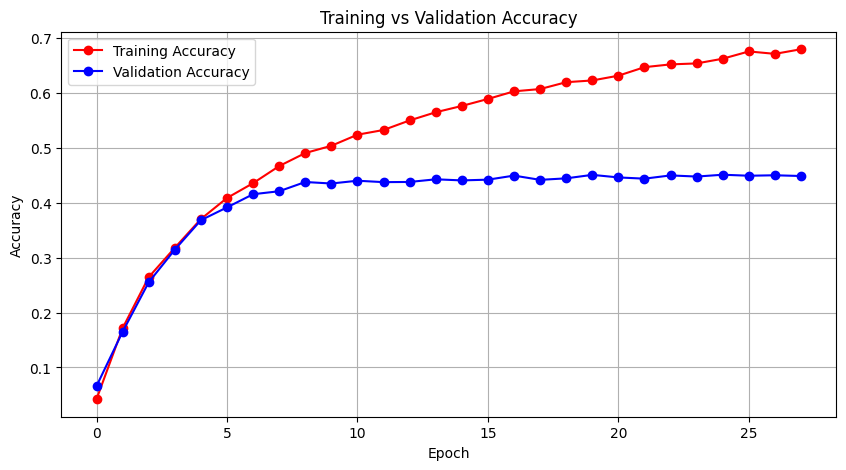

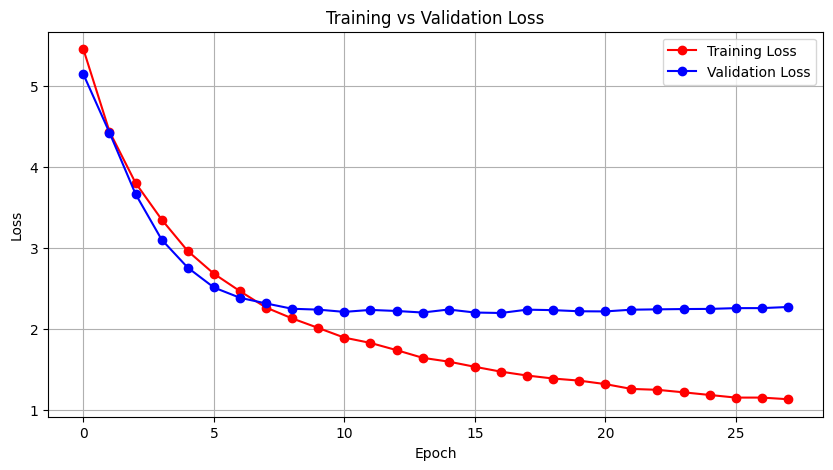

In [ ]:
import matplotlib.pyplot as plt

accuracy = history3.history['accuracy']
loss = history3.history['loss']

plt.figure(figsize=(10, 5))
plt.plot(accuracy, label='Training Accuracy', marker='o', color='red')
plt.plot(history3.history['val_accuracy'], marker='o', color='blue', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss', marker='o', color='red')
plt.plot(history3.history['val_loss'], marker='o', color='blue', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Ottenere le predizioni
predictions = final_model.predict(val_ds)

# 2. Convertire le predizioni in classi (indice della classe con probabilità massima)
predicted_classes = np.argmax(predictions, axis=1)

# 3. Estrarre le label reali (da val_ds)
true_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in val_ds])

# 4. Calcolare l'accuracy
accuracy = accuracy_score(true_labels, predicted_classes)

print(f'Validation Accuracy: {accuracy:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 45s 352ms/step
Validation Accuracy: 0.4496


In [56]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Ottenere le predizioni
predictions = final_model.predict(test_ds)

# 2. Convertire le predizioni in classi (indice della classe con probabilità massima)
predicted_classes = np.argmax(predictions, axis=1)

# 3. Estrarre le label reali (da val_ds)
true_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in val_ds])

# 4. Calcolare l'accuracy
accuracy = accuracy_score(true_labels, predicted_classes)

print(f'Test Accuracy: {accuracy:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step
Test Accuracy: 0.3105


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
from sklearn.metrics import accuracy_score

predictions = final_model.predict(unlabeled_ds)

num_predictions = predictions.shape[0]
print(f"Numero di predizioni: {num_predictions}")

predicted_classes = np.argmax(predictions, axis=1)
confidences = np.max(predictions, axis=1)  # Confidenza basata su max softmax

assert len(predicted_classes) == num_predictions, "Errore: predicted_classes ha lunghezza errata"
assert len(confidences) == num_predictions, "Errore: confidences ha lunghezza errata"

entropies = entropy(predictions.T, axis=0)  # Assicura che l'entropia sia calcolata correttamente

assert len(entropies) == num_predictions, "Errore: l'entropia non ha la stessa lunghezza delle predizioni"

image_paths = []
for i, img_batch in enumerate(unlabeled_ds.unbatch()):
    if isinstance(img_batch, tuple):
        img = img_batch[0]  # Se il dataset ha tuple (img, label), prendiamo solo l'immagine
    else:
        img = img_batch  # Se il dataset ha solo immagini
    formatted_num = str(i).zfill(6)
    image_paths.append(f"train_{formatted_num}.jpg")  # Placeholder per i nomi delle immagini

assert len(image_paths) == num_predictions, f"Errore: {len(image_paths)} immagini vs {num_predictions} predizioni"

results_df2 = pd.DataFrame({
    'Percorso Immagine': image_paths,
    'Classe Predetta': predicted_classes,
    'Confidenza (Max Softmax)': confidences,
    'Entropia (Incertezza)': entropies
})

display(results_df2)

744/744 ━━━━━━━━━━━━━━━━━━━━ 192s 241ms/step
Numero di predizioni: 95194


,Percorso Immagine,Classe Predetta,Confidenza (Max Softmax),Entropia (Incertezza)
0,train_000000.jpg,163,0.974126,0.125587
1,train_000001.jpg,163,0.978999,0.103075
2,train_000002.jpg,163,0.672427,1.080882
3,train_000003.jpg,163,0.843087,0.486907
4,train_000004.jpg,163,0.738655,1.011756
...,...,...,...,...
95189,train_095189.jpg,28,0.446037,1.675301
95190,train_095190.jpg,164,0.570425,0.974291
95191,train_095191.jpg,28,0.512026,1.093096
95192,train_095192.jpg,28,0.962986,0.239670


In [ ]:
# Visualizziamo i primi risultati ordinati per entropia crescente
df = results_df2.sort_values(by='Entropia (Incertezza)', ascending=True)
dataset_per_immagini2 = df[df['Entropia (Incertezza)'] <= 0.03]
dataset_per_immagini2 = dataset_per_immagini2[dataset_per_immagini2['Confidenza (Max Softmax)'] >= 0.98]
dataset_per_immagini2 = dataset_per_immagini2[['Percorso Immagine','Classe Predetta']]
print(dataset_per_immagini2.shape)
dataset_per_immagini2.head(3)

(830, 2)


,Percorso Immagine,Classe Predetta
89349,train_089349.jpg,239
60429,train_060429.jpg,103
60195,train_060195.jpg,103


In [59]:
df_1 = pd.read_csv('/kaggle/working/df_per_immagini1.csv')
dataset_per_immagini2 = dataset_per_immagini2[
    ~dataset_per_immagini2['Percorso Immagine'].isin(df_1['Percorso Immagine'])
]

In [60]:
print(dataset_per_immagini2.shape)

(448, 2)


In [61]:
dataset_per_immagini2.to_csv("/kaggle/working/df_immagini2.csv", index=False)

In [ ]:
import tensorflow as tf
import pathlib
import numpy as np

unlabeled_data_dir = pathlib.Path('/kaggle/input/train-set-unlabeled/train_set_unlabeled/-1')
df=dataset_per_immagini2
df['Percorso Immagine'] = df['Percorso Immagine'].apply(lambda x: x.split('/')[-1])
df['Percorso Immagine'] = df['Percorso Immagine'].apply(lambda x: x.split('_')[0] + '_' + x.split('_')[1].zfill(6))

image_dict = dict(zip(df['Percorso Immagine'], df['Classe Predetta']))

image_paths = sorted(unlabeled_data_dir.glob('*.jpg'))

to_add_images = [str(image_path) for image_path in image_paths if image_path.name in image_dict]

to_add_labels = [image_dict[image_path.name] for image_path in image_paths if image_path.name in image_dict]

num_classes = 251  # Numero di classi uniche
to_add_labels = np.array(to_add_labels, dtype=np.int32)  # Converti in interi
to_add_labels_one_hot = tf.one_hot(to_add_labels, num_classes)  # One-hot encoding

def process_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decodifica come immagine RGB
    image = tf.image.resize(image, (224, 224))  # Ridimensiona
    image = tf.cast(image, tf.float32) / 255.0  # Normalizzazione tra 0 e 1
    return image

image_ds = tf.data.Dataset.from_tensor_slices(to_add_images)
image_ds = image_ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

label_ds = tf.data.Dataset.from_tensor_slices(to_add_labels_one_hot)

image_ds = tf.data.Dataset.zip((image_ds, label_ds))
image_ds = image_ds.batch(128).prefetch(tf.data.AUTOTUNE)

print(f"✅ image_ds creato con {len(to_add_images)} immagini.")

train_data_dir = pathlib.Path('/kaggle/input/clean-train-no-outliers')

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=128,
    shuffle=True,
    seed=42
).prefetch(tf.data.AUTOTUNE)

print(f"✅ train_ds caricato.")

for image, label in train_ds.take(1):
    print(f"train_ds shape: {image.shape}, {label.shape}")

for image, label in image_ds.take(1):
    print(f"image_ds shape: {image.shape}, {label.shape}")

train_ds = train_ds.concatenate(image_ds)

num_images_in_train_ds = sum(1 for _ in train_ds)
print(f"✅ Numero totale di immagini in train_ds dopo concatenamento: {num_images_in_train_ds}")

✅ image_ds creato con 418 immagini.
Found 4883 files belonging to 251 classes.
✅ train_ds caricato.
train_ds shape: (128, 224, 224, 3), (128, 251)
image_ds shape: (128, 224, 224, 3), (128, 251)
✅ Numero totale di immagini in train_ds dopo concatenamento: 43


## terzo image augmentation

In [ ]:
train_data_dir = pathlib.Path('/kaggle/input/trainset-augmented2/train_set_augmented2')

batch_size = 128
image_size = (224, 224)

train_ds3 = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=42
)
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds3 = train_ds3.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds3 = train_ds3.prefetch(buffer_size=tf.data.AUTOTUNE)
print("Train dataset ready.")

Found 8341 files belonging to 251 classes.
Train dataset ready.


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation

def custom_layer_wrapper(layer_class):
    def wrapper(*args, **kwargs):
        if 'name' in kwargs:
            kwargs['name'] = kwargs['name'].replace('/', '_')  # Sostituisce "/" con "_"
        return layer_class(*args, **kwargs)
    return wrapper

custom_conv2d = custom_layer_wrapper(Conv2D)
custom_batch_norm = custom_layer_wrapper(BatchNormalization)
custom_activation = custom_layer_wrapper(Activation)

model_path = '/kaggle/input/resnet_kaggle1/other/default/1/RESNET_Kaggle.hdf5'

resnet_kaggle_model = tf.keras.models.load_model(
    model_path,
    custom_objects={
        'Conv2D': custom_conv2d,
        'BatchNormalization': custom_batch_norm,
        'Activation': custom_activation
    }
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Resizing, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

input_layer = Input(shape=(224, 224, 3))

resnet_kaggle_model.trainable = False

output_layer = resnet_kaggle_model.get_layer("global_average_pooling2d").output
intermediate_model = Model(inputs=resnet_kaggle_model.input, outputs=output_layer)

x = intermediate_model(input_layer)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

output = Dense(251, activation='softmax')(x)

final_model = Model(inputs=input_layer, outputs=output)
optimizer = Adam(learning_rate=0.001)
final_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

final_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional (Functional)              │ (None, 1920)                │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         983,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 251)                 │          32,379 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,505,723 (74.41 MB)

 Trainable params: 1,181,947 (4.51 MB)

 Non-trainable params: 18,323,776 (69.90 MB)

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
# Definizione dei callback 
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=11, restore_best_weights=True)

history4 = final_model.fit(
    train_ds3,
    epochs=50,
    validation_data=val_ds,
    verbose=1,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.0246 - loss: 5.6669 - val_accuracy: 0.0480 - val_loss: 5.0779 - learning_rate: 0.0010
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 37s 561ms/step - accuracy: 0.1804 - loss: 4.4090 - val_accuracy: 0.1651 - val_loss: 4.2438 - learning_rate: 0.0010
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 37s 561ms/step - accuracy: 0.2694 - loss: 3.7738 - val_accuracy: 0.2336 - val_loss: 3.5669 - learning_rate: 0.0010
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 37s 561ms/step - accuracy: 0.3270 - loss: 3.2957 - val_accuracy: 0.2986 - val_loss: 3.0797 - learning_rate: 0.0010
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 37s 562ms/step - accuracy: 0.3742 - loss: 2.9368 - val_accuracy: 0.3462 - val_loss: 2.7381 - learning_rate: 0.0010
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 37s 561ms/step - accuracy: 0.4143 - loss: 2.6182 - val_accuracy: 0.3772 - val_loss: 2.5474 - learning_rate: 0.0010
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 37s 562ms/step - accuracy: 0.4532 - loss: 2.38

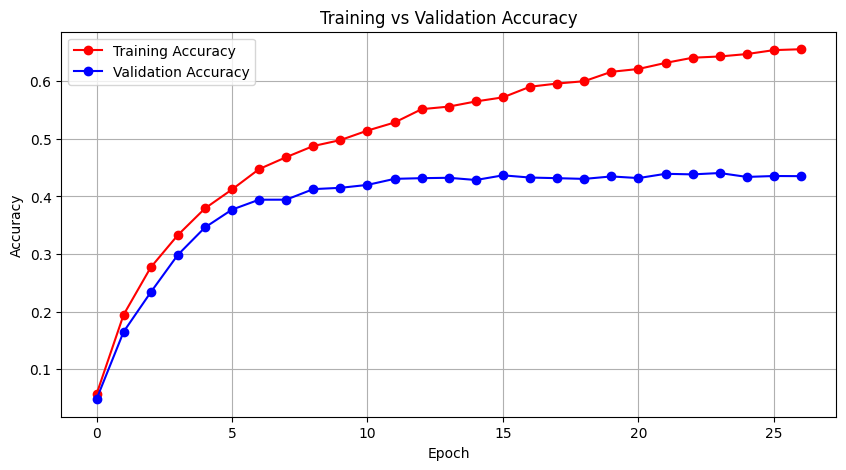

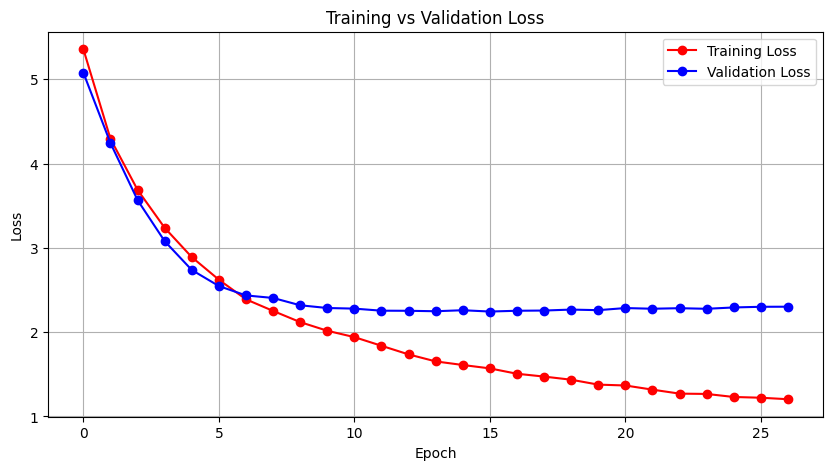

In [ ]:
import matplotlib.pyplot as plt
accuracy = history4.history['accuracy']
loss = history4.history['loss']

plt.figure(figsize=(10, 5))
plt.plot(accuracy, label='Training Accuracy', marker='o', color='red')
plt.plot(history4.history['val_accuracy'], marker='o', color='blue', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss', marker='o', color='red')
plt.plot(history4.history['val_loss'], marker='o', color='blue', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Ottenere le predizioni
predictions = final_model.predict(val_ds)

# 2. Convertire le predizioni in classi (indice della classe con probabilità massima)
predicted_classes = np.argmax(predictions, axis=1)

# 3. Estrarre le label reali (da val_ds)
true_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in val_ds])

# 4. Calcolare l'accuracy
accuracy = accuracy_score(true_labels, predicted_classes)

print(f'Validation Accuracy: {accuracy:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 47s 364ms/step
Validation Accuracy: 0.4367


In [11]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Ottenere le predizioni
predictions = final_model.predict(test_ds)

# 2. Convertire le predizioni in classi (indice della classe con probabilità massima)
predicted_classes = np.argmax(predictions, axis=1)

# 3. Estrarre le label reali (da val_ds)
true_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in val_ds])

# 4. Calcolare l'accuracy
accuracy = accuracy_score(true_labels, predicted_classes)

print(f'Test Accuracy: {accuracy:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 280ms/step
Test Accuracy: 0.2970


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
from sklearn.metrics import accuracy_score

predictions = final_model.predict(unlabeled_ds)

num_predictions = predictions.shape[0]
print(f"Numero di predizioni: {num_predictions}")

predicted_classes = np.argmax(predictions, axis=1)
confidences = np.max(predictions, axis=1)  # Confidenza basata su max softmax

assert len(predicted_classes) == num_predictions, "Errore: predicted_classes ha lunghezza errata"
assert len(confidences) == num_predictions, "Errore: confidences ha lunghezza errata"

entropies = entropy(predictions.T, axis=0)  # Assicura che l'entropia sia calcolata correttamente

assert len(entropies) == num_predictions, "Errore: l'entropia non ha la stessa lunghezza delle predizioni"

image_paths = []

for i, img_batch in enumerate(unlabeled_ds.unbatch()):
    if isinstance(img_batch, tuple):
        img = img_batch[0]  # Se il dataset ha tuple (img, label), prendiamo solo l'immagine
    else:
        img = img_batch  # Se il dataset ha solo immagini
    formatted_num = str(i).zfill(6)
    image_paths.append(f"train_{formatted_num}.jpg")  # Placeholder per i nomi delle immagini

assert len(image_paths) == num_predictions, f"Errore: {len(image_paths)} immagini vs {num_predictions} predizioni"

results_df3 = pd.DataFrame({
    'Percorso Immagine': image_paths,
    'Classe Predetta': predicted_classes,
    'Confidenza (Max Softmax)': confidences,
    'Entropia (Incertezza)': entropies
})

display(results_df3)

744/744 ━━━━━━━━━━━━━━━━━━━━ 189s 239ms/step
Numero di predizioni: 95194


,Percorso Immagine,Classe Predetta,Confidenza (Max Softmax),Entropia (Incertezza)
0,train_000000.jpg,163,0.972113,0.135327
1,train_000001.jpg,163,0.984103,0.082693
2,train_000002.jpg,163,0.651491,1.875743
3,train_000003.jpg,163,0.927958,0.317007
4,train_000004.jpg,163,0.349166,3.259409
...,...,...,...,...
95189,train_095189.jpg,28,0.641276,1.961472
95190,train_095190.jpg,164,0.638872,0.990108
95191,train_095191.jpg,28,0.875024,0.574901
95192,train_095192.jpg,28,0.960058,0.253270


In [ ]:
df = results_df3.sort_values(by='Entropia (Incertezza)', ascending=True)
dataset_per_immagini3 = df[df['Entropia (Incertezza)'] <= 0.03]
dataset_per_immagini3 = dataset_per_immagini3[dataset_per_immagini3['Confidenza (Max Softmax)'] >= 0.98]
dataset_per_immagini3 = dataset_per_immagini3[['Percorso Immagine','Classe Predetta']]
print(dataset_per_immagini3.shape)
dataset_per_immagini3.head(3)

(652, 2)


,Percorso Immagine,Classe Predetta
34106,train_034106.jpg,195
65690,train_065690.jpg,231
34363,train_034363.jpg,195


In [15]:
df_1 = pd.read_csv('/kaggle/input/df-per-immagini/df_per_immagini1.csv')
df_2 = pd.read_csv('/kaggle/input/df-per-immagini/df_immagini2.csv')
dataset_per_immagini3 = dataset_per_immagini3[
    ~dataset_per_immagini3['Percorso Immagine'].isin(df_1['Percorso Immagine'])
]
dataset_per_immagini3 = dataset_per_immagini3[
    ~dataset_per_immagini3['Percorso Immagine'].isin(df_2['Percorso Immagine'])
]

In [16]:
print(dataset_per_immagini3.shape)

(232, 2)


In [17]:
dataset_per_immagini3.to_csv("/kaggle/working/df_immagini3.csv", index=False)

In [ ]:
import tensorflow as tf
import pathlib
import numpy as np

unlabeled_data_dir = pathlib.Path('/kaggle/input/train-set-unlabeled/train_set_unlabeled/-1')
df=dataset_per_immagini3
df['Percorso Immagine'] = df['Percorso Immagine'].apply(lambda x: x.split('/')[-1])
df['Percorso Immagine'] = df['Percorso Immagine'].apply(lambda x: x.split('_')[0] + '_' + x.split('_')[1].zfill(6))

image_dict = dict(zip(df['Percorso Immagine'], df['Classe Predetta']))

image_paths = sorted(unlabeled_data_dir.glob('*.jpg'))

to_add_images = [str(image_path) for image_path in image_paths if image_path.name in image_dict]

to_add_labels = [image_dict[image_path.name] for image_path in image_paths if image_path.name in image_dict]

num_classes = 251  # Numero di classi uniche
to_add_labels = np.array(to_add_labels, dtype=np.int32)  # Converti in interi
to_add_labels_one_hot = tf.one_hot(to_add_labels, num_classes)  # One-hot encoding

def process_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decodifica come immagine RGB
    image = tf.image.resize(image, (224, 224))  # Ridimensiona
    image = tf.cast(image, tf.float32) / 255.0  # Normalizzazione tra 0 e 1
    return image

image_ds = tf.data.Dataset.from_tensor_slices(to_add_images)
image_ds = image_ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

label_ds = tf.data.Dataset.from_tensor_slices(to_add_labels_one_hot)

image_ds = tf.data.Dataset.zip((image_ds, label_ds))
image_ds = image_ds.batch(128).prefetch(tf.data.AUTOTUNE)

print(f"✅ image_ds creato con {len(to_add_images)} immagini.")

# Caricamento del dataset etichettato (train_ds)
train_data_dir = pathlib.Path('/kaggle/input/clean-train-no-outliers')

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=128,
    shuffle=True,
    seed=42
).prefetch(tf.data.AUTOTUNE)

print(f"✅ train_ds caricato.")

# Controlliamo che le forme di `image_ds` e `train_ds` siano compatibili prima della concatenazione
for image, label in train_ds.take(1):
    print(f"train_ds shape: {image.shape}, {label.shape}")

for image, label in image_ds.take(1):
    print(f"image_ds shape: {image.shape}, {label.shape}")
# Combiniamo i dataset
train_ds = train_ds.concatenate(image_ds)

# Contiamo il numero totale di immagini
num_images_in_train_ds = sum(1 for _ in train_ds)
print(f"✅ Numero totale di immagini in train_ds dopo concatenamento: {num_images_in_train_ds}")

✅ image_ds creato con 216 immagini.
Found 4883 files belonging to 251 classes.
✅ train_ds caricato.
train_ds shape: (128, 224, 224, 3), (128, 251)
image_ds shape: (128, 224, 224, 3), (128, 251)
✅ Numero totale di immagini in train_ds dopo concatenamento: 41


## Last Model

In [ ]:
train_data_dir = pathlib.Path('/kaggle/input/train-set-augmented3/train_set_augmented3')

batch_size = 128
image_size = (224, 224)

train_ds4 = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=42
)
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds4 = train_ds4.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds4 = train_ds4.prefetch(buffer_size=tf.data.AUTOTUNE)
print("Train dataset ready.")

Found 8557 files belonging to 251 classes.
Train dataset ready.


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation

def custom_layer_wrapper(layer_class):
    def wrapper(*args, **kwargs):
        if 'name' in kwargs:
            kwargs['name'] = kwargs['name'].replace('/', '_')  # Sostituisce "/" con "_"
        return layer_class(*args, **kwargs)
    return wrapper

custom_conv2d = custom_layer_wrapper(Conv2D)
custom_batch_norm = custom_layer_wrapper(BatchNormalization)
custom_activation = custom_layer_wrapper(Activation)

model_path = '/kaggle/input/resnet_kaggle1/other/default/1/RESNET_Kaggle.hdf5'

resnet_kaggle_model = tf.keras.models.load_model(
    model_path,
    custom_objects={
        'Conv2D': custom_conv2d,
        'BatchNormalization': custom_batch_norm,
        'Activation': custom_activation
    }
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Resizing, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

input_layer = Input(shape=(224, 224, 3))

resnet_kaggle_model.trainable = False

output_layer = resnet_kaggle_model.get_layer("global_average_pooling2d").output
intermediate_model = Model(inputs=resnet_kaggle_model.input, outputs=output_layer)

x = intermediate_model(input_layer)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

output = Dense(251, activation='softmax')(x)

final_model = Model(inputs=input_layer, outputs=output)
optimizer = Adam(learning_rate=0.001)
final_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

final_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_2 (Functional)            │ (None, 1920)                │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         983,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 251)                 │          32,379 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,505,723 (74.41 MB)

 Trainable params: 1,181,947 (4.51 MB)

 Non-trainable params: 18,323,776 (69.90 MB)

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
# Definizione dei callback 
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=11, restore_best_weights=True)

history4 = final_model.fit(
    train_ds4,
    epochs=50,
    validation_data=val_ds,
    verbose=1,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.0255 - loss: 5.6836 - val_accuracy: 0.0694 - val_loss: 5.0410 - learning_rate: 0.0010
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 558ms/step - accuracy: 0.1813 - loss: 4.4360 - val_accuracy: 0.1504 - val_loss: 4.2902 - learning_rate: 0.0010
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 559ms/step - accuracy: 0.2649 - loss: 3.7701 - val_accuracy: 0.2231 - val_loss: 3.6177 - learning_rate: 0.0010
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 559ms/step - accuracy: 0.3188 - loss: 3.2893 - val_accuracy: 0.2989 - val_loss: 3.0644 - learning_rate: 0.0010
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 559ms/step - accuracy: 0.3759 - loss: 2.9144 - val_accuracy: 0.3384 - val_loss: 2.7669 - learning_rate: 0.0010
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 558ms/step - accuracy: 0.4160 - loss: 2.6153 - val_accuracy: 0.3694 - val_loss: 2.5330 - learning_rate: 0.0010
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 37s 559ms/step - accuracy: 0.4414 - loss: 2.42

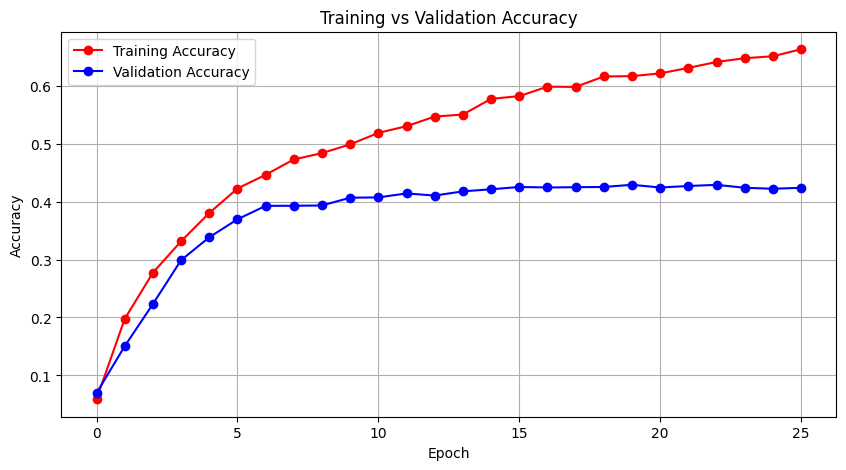

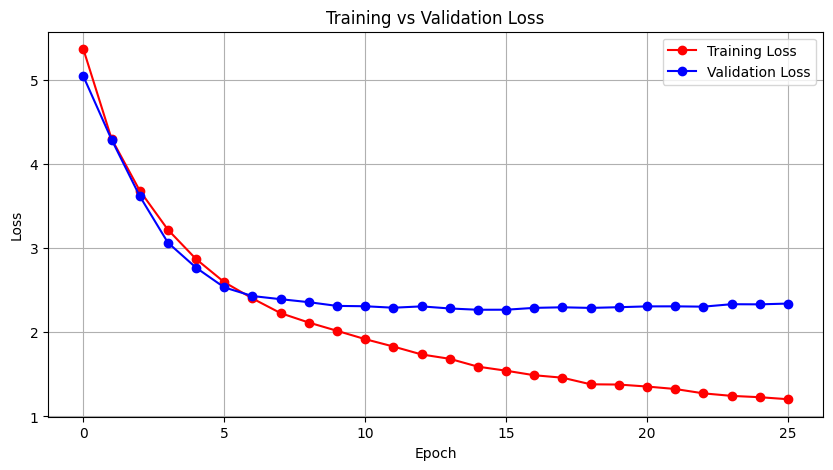

In [ ]:
import matplotlib.pyplot as plt
accuracy = history4.history['accuracy']
loss = history4.history['loss']

plt.figure(figsize=(10, 5))
plt.plot(accuracy, label='Training Accuracy', marker='o', color='red')
plt.plot(history4.history['val_accuracy'], marker='o', color='blue', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss', marker='o', color='red')
plt.plot(history4.history['val_loss'], marker='o', color='blue', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Ottenere le predizioni
predictions = final_model.predict(val_ds)

# 2. Convertire le predizioni in classi (indice della classe con probabilità massima)
predicted_classes = np.argmax(predictions, axis=1)

# 3. Estrarre le label reali (da val_ds)
true_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in val_ds])

# 4. Calcolare l'accuracy
accuracy = accuracy_score(true_labels, predicted_classes)

print(f'Validation Accuracy: {accuracy:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 43s 343ms/step
Validation Accuracy: 0.4213


In [24]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Ottenere le predizioni
predictions = final_model.predict(test_ds)

# 2. Convertire le predizioni in classi (indice della classe con probabilità massima)
predicted_classes = np.argmax(predictions, axis=1)

# 3. Estrarre le label reali (da val_ds)
true_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in val_ds])

# 4. Calcolare l'accuracy
accuracy = accuracy_score(true_labels, predicted_classes)

print(f'Test Accuracy: {accuracy:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step
Test Accuracy: 0.2892


## Modello migliore con test migliorato

In [2]:
import os
import pathlib
import zipfile
import tensorflow as tf
import pandas as pd
import numpy as np

In [ ]:

train_data_dir = pathlib.Path('/kaggle/input/clean-train-no-outliers')

batch_size = 128
image_size = (224, 224)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=42
)
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
print("Train dataset ready.")

Found 4883 files belonging to 251 classes.
Train dataset ready.


In [3]:
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [ ]:
val_data_dir = pathlib.Path('/kaggle/input/val-set-class/val_set_class')

# Creazione del dataset di addestramento
batch_size = 128
image_size = (224, 224)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    seed=42
)
val_ds = val_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
print("Val dataset ready.")

Found 11994 files belonging to 251 classes.
Val dataset ready.


In [ ]:
test_data_dir = pathlib.Path('/kaggle/input/val-set-degraded-class/val_set_degraded_class')

# Creazione del dataset di addestramento
batch_size = 128
image_size = (224, 224)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    seed=42
)
test_ds = test_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
print("Test dataset ready.")

Found 11994 files belonging to 251 classes.
Test dataset ready.


In [ ]:
test_data_dir = pathlib.Path('/kaggle/input/val-set-enhanced')

# Creazione del dataset di addestramento
batch_size = 128
image_size = (224, 224)

test_enhanched_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    seed=42
)
test_enhanched_ds = test_enhanched_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
test_enhanched_ds = test_enhanched_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
print("Test enhanced dataset ready.")

Found 11994 files belonging to 251 classes.
Test enhanced dataset ready.


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation

def custom_layer_wrapper(layer_class):
    def wrapper(*args, **kwargs):
        if 'name' in kwargs:
            kwargs['name'] = kwargs['name'].replace('/', '_')  # Sostituisce "/" con "_"
        return layer_class(*args, **kwargs)
    return wrapper

custom_conv2d = custom_layer_wrapper(Conv2D)
custom_batch_norm = custom_layer_wrapper(BatchNormalization)
custom_activation = custom_layer_wrapper(Activation)

model_path = '/kaggle/input/resnet_kaggle1/other/default/1/RESNET_Kaggle.hdf5'

resnet_kaggle_model = tf.keras.models.load_model(
    model_path,
    custom_objects={
        'Conv2D': custom_conv2d,
        'BatchNormalization': custom_batch_norm,
        'Activation': custom_activation
    }
)

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation

def custom_layer_wrapper(layer_class):
    def wrapper(*args, **kwargs):
        if 'name' in kwargs:
            kwargs['name'] = kwargs['name'].replace('/', '_')  # Sostituisce "/" con "_"
        return layer_class(*args, **kwargs)
    return wrapper

custom_conv2d = custom_layer_wrapper(Conv2D)
custom_batch_norm = custom_layer_wrapper(BatchNormalization)
custom_activation = custom_layer_wrapper(Activation)

model_path = '/kaggle/input/resnet_kaggle1/other/default/1/RESNET_Kaggle.hdf5'

resnet_kaggle_model = tf.keras.models.load_model(
    model_path,
    custom_objects={
        'Conv2D': custom_conv2d,
        'BatchNormalization': custom_batch_norm,
        'Activation': custom_activation
    }
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Resizing, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

input_layer = Input(shape=(224, 224, 3))

resnet_kaggle_model.trainable = False

output_layer = resnet_kaggle_model.get_layer("global_average_pooling2d").output
intermediate_model = Model(inputs=resnet_kaggle_model.input, outputs=output_layer)

x = intermediate_model(input_layer)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

output = Dense(251, activation='softmax')(x)

final_model = Model(inputs=input_layer, outputs=output)
optimizer = Adam(learning_rate=0.001)
final_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

final_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_2 (Functional)            │ (None, 1920)                │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         983,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 251)                 │          32,379 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,505,723 (74.41 MB)

 Trainable params: 1,181,947 (4.51 MB)

 Non-trainable params: 18,323,776 (69.90 MB)

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
# Definizione dei callback
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=11, restore_best_weights=True)

# Addestramento del modello con callback
history4 = final_model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    verbose=1,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.0114 - loss: 5.7788 - val_accuracy: 0.0806 - val_loss: 5.1228 - learning_rate: 0.0010
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 804ms/step - accuracy: 0.0915 - loss: 4.7270 - val_accuracy: 0.3459 - val_loss: 4.4103 - learning_rate: 0.0010
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 804ms/step - accuracy: 0.2625 - loss: 3.9649 - val_accuracy: 0.4659 - val_loss: 3.6376 - learning_rate: 0.0010
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 803ms/step - accuracy: 0.3751 - loss: 3.3739 - val_accuracy: 0.5108 - val_loss: 2.9442 - learning_rate: 0.0010
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 803ms/step - accuracy: 0.4485 - loss: 2.9371 - val_accuracy: 0.5489 - val_loss: 2.4251 - learning_rate: 0.0010
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 804ms/step - accuracy: 0.5029 - loss: 2.5755 - val_accuracy: 0.5631 - val_loss: 2.1589 - learning_rate: 0.0010
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 804ms/step - accuracy: 0.5845 - loss: 2.18

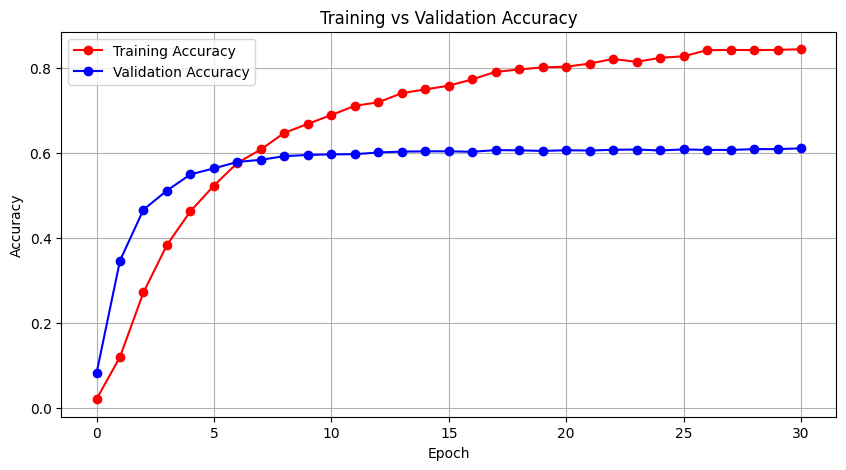

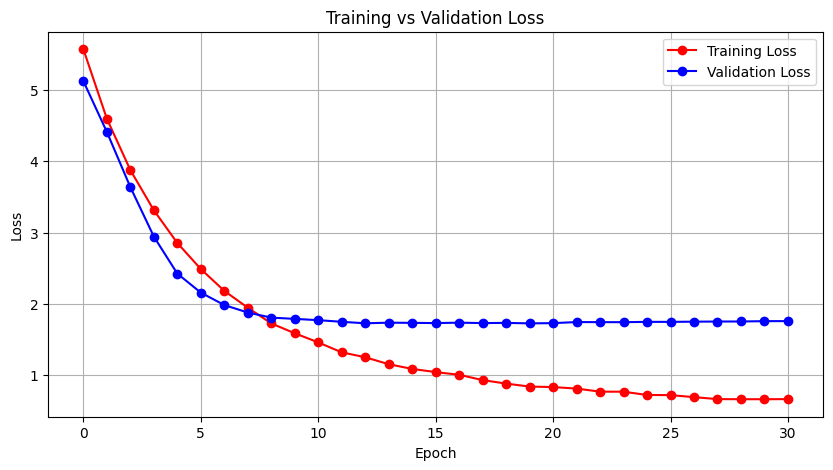

In [ ]:
import matplotlib.pyplot as plt
accuracy = history4.history['accuracy']
loss = history4.history['loss']

plt.figure(figsize=(10, 5))
plt.plot(accuracy, label='Training Accuracy', marker='o', color='red')
plt.plot(history4.history['val_accuracy'], marker='o', color='blue', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss', marker='o', color='red')
plt.plot(history4.history['val_loss'], marker='o', color='blue', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Ottenere le predizioni
predictions = final_model.predict(val_ds)

# 2. Convertire le predizioni in classi (indice della classe con probabilità massima)
predicted_classes = np.argmax(predictions, axis=1)

# 3. Estrarre le label reali (da val_ds)
true_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in val_ds])

# 4. Calcolare l'accuracy
accuracy_val = accuracy_score(true_labels, predicted_classes)

print(f'Validation Accuracy: {accuracy_val:.4f}')

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Ottenere le predizioni
predictions = final_model.predict(test_ds)

# 2. Convertire le predizioni in classi (indice della classe con probabilità massima)
predicted_classes = np.argmax(predictions, axis=1)

# 3. Estrarre le label reali (da val_ds)
true_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in test_ds])

# 4. Calcolare l'accuracy
accuracy_test = accuracy_score(true_labels, predicted_classes)

print(f'Test Accuracy: {accuracy_test:.4f}')

19/94 ━━━━━━━━━━━━━━━━━━━━ 16s 224ms/step

In [17]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Ottenere le predizioni
predictions = final_model.predict(test_enhanched_ds)

# 2. Convertire le predizioni in classi (indice della classe con probabilità massima)
predicted_classes = np.argmax(predictions, axis=1)

# 3. Estrarre le label reali (da val_ds)
true_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in test_enhanched_ds])

# 4. Calcolare l'accuracy
accuracy_enhanced = accuracy_score(true_labels, predicted_classes)

print(f'Test Enhanced Accuracy: {accuracy_enhanced:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 65s 539ms/step
Test Enhanced Accuracy: 0.4172


In [ ]:
print(f'Validation Accuracy: {accuracy_val:.4f}')
print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Enhanced Accuracy: {accuracy_enhanced:.4f}')

## Modello finale con data augmentation

In [ ]:
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

data_dir = pathlib.Path('/kaggle/input/clean-train-no-outliers')

batch_size = 128
image_size = (224, 224)

# Creazione dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

# Definizione delle Data Augmentation
augmentation_layer = keras.Sequential([
    layers.RandomFlip("horizontal and vertical"),
    layers.RandomRotation(0.2),  # Rotazione fino a 45 gradi
    layers.RandomContrast(0.1),  # Aggiustamento contrasto
    layers.RandomBrightness(0.2),  # Aggiustamento luminosità
    layers.Rescaling(1.0 / 255)  # Normalizzazione
])

def augment(image, label):
    return augmentation_layer(image), label

# Applicazione della data augmentation
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

print("Dataset con Data Augmentation pronto.")

Found 4883 files belonging to 251 classes.
Dataset con Data Augmentation pronto.


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation

def custom_layer_wrapper(layer_class):
    def wrapper(*args, **kwargs):
        if 'name' in kwargs:
            kwargs['name'] = kwargs['name'].replace('/', '_')  # Sostituisce "/" con "_"
        return layer_class(*args, **kwargs)
    return wrapper

custom_conv2d = custom_layer_wrapper(Conv2D)
custom_batch_norm = custom_layer_wrapper(BatchNormalization)
custom_activation = custom_layer_wrapper(Activation)

model_path = '/kaggle/input/resnet_kaggle1/other/default/1/RESNET_Kaggle.hdf5'

resnet_kaggle_model = tf.keras.models.load_model(
    model_path,
    custom_objects={
        'Conv2D': custom_conv2d,
        'BatchNormalization': custom_batch_norm,
        'Activation': custom_activation
    }
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Resizing, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
input_layer = Input(shape=(224, 224, 3))

resnet_kaggle_model.trainable = False

output_layer = resnet_kaggle_model.get_layer("global_average_pooling2d").output
intermediate_model = Model(inputs=resnet_kaggle_model.input, outputs=output_layer)

x = intermediate_model(input_layer)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

output = Dense(251, activation='softmax')(x)

final_model = Model(inputs=input_layer, outputs=output)
optimizer = Adam(learning_rate=0.001)
final_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

final_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_4 (Functional)            │ (None, 1920)                │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         983,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 251)                 │          32,379 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,505,723 (74.41 MB)

 Trainable params: 1,181,947 (4.51 MB)

 Non-trainable params: 18,323,776 (69.90 MB)

a

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history4 = final_model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    verbose=1,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.0043 - loss: 5.8988 - val_accuracy: 0.0445 - val_loss: 5.2255 - learning_rate: 0.0010
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 939ms/step - accuracy: 0.0512 - loss: 5.1416 - val_accuracy: 0.2263 - val_loss: 4.7120 - learning_rate: 0.0010
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 937ms/step - accuracy: 0.1176 - loss: 4.5969 - val_accuracy: 0.3834 - val_loss: 4.0093 - learning_rate: 0.0010
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 935ms/step - accuracy: 0.1940 - loss: 4.1804 - val_accuracy: 0.4562 - val_loss: 3.3095 - learning_rate: 0.0010
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 948ms/step - accuracy: 0.2590 - loss: 3.8191 - val_accuracy: 0.4839 - val_loss: 2.8700 - learning_rate: 0.0010
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 944ms/step - accuracy: 0.2993 - loss: 3.5234 - val_accuracy: 0.5046 - val_loss: 2.5202 - learning_rate: 0.0010
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 37s 938ms/step - accuracy: 0.3316 - los

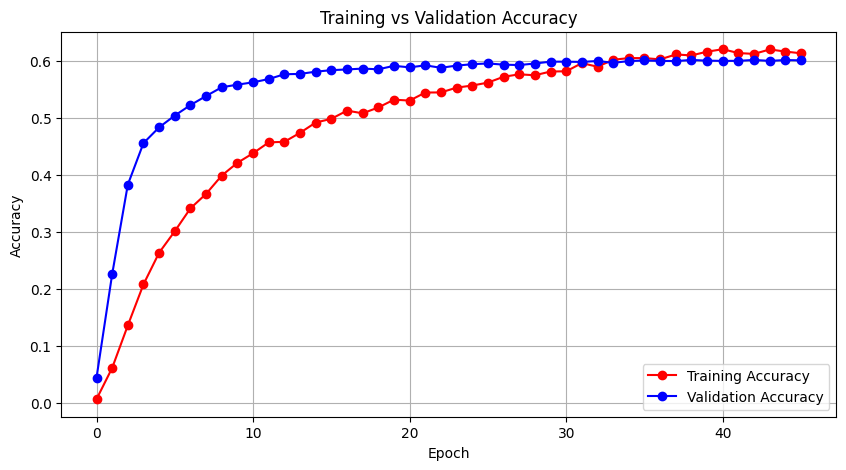

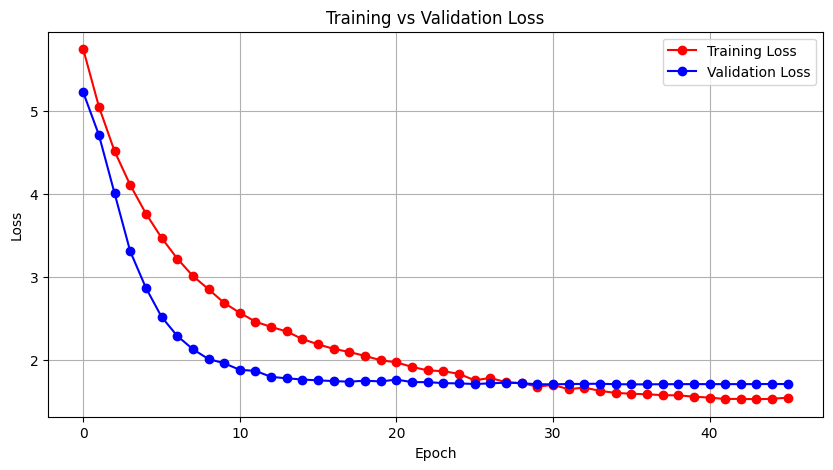

In [ ]:
import matplotlib.pyplot as plt
accuracy = history4.history['accuracy']
loss = history4.history['loss']

plt.figure(figsize=(10, 5))
plt.plot(accuracy, label='Training Accuracy', marker='o', color='red')
plt.plot(history4.history['val_accuracy'], marker='o', color='blue', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss', marker='o', color='red')
plt.plot(history4.history['val_loss'], marker='o', color='blue', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
final_model.save("/kaggle/working/mymodel_aug.keras")  # Salvataggio nel formato nativo di Keras

In [ ]:
from tensorflow.keras.models import load_model

final_model = load_model("/kaggle/working/mymodel_aug.keras") 

In [13]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Ottenere le predizioni
predictions = final_model.predict(val_ds)

# 2. Convertire le predizioni in classi (indice della classe con probabilità massima)
predicted_classes = np.argmax(predictions, axis=1)

# 3. Estrarre le label reali (da val_ds)
true_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in val_ds])

# 4. Calcolare l'accuracy
accuracy_val = accuracy_score(true_labels, predicted_classes)

print(f'Validation Accuracy: {accuracy_val:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 49s 371ms/step
Validation Accuracy: 0.6012


In [8]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Ottenere le predizioni
predictions = final_model.predict(test_ds)

# 2. Convertire le predizioni in classi (indice della classe con probabilità massima)
predicted_classes = np.argmax(predictions, axis=1)

# 3. Estrarre le label reali (da val_ds)
true_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in test_ds])

# 4. Calcolare l'accuracy
accuracy_test = accuracy_score(true_labels, predicted_classes)

print(f'Test Accuracy: {accuracy_test:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 278ms/step
Test Accuracy: 0.4212


In [6]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Ottenere le predizioni
predictions = final_model.predict(test_enhanched_ds)

# 2. Convertire le predizioni in classi (indice della classe con probabilità massima)
predicted_classes = np.argmax(predictions, axis=1)

# 3. Estrarre le label reali
true_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in test_enhanched_ds])

# 4. Calcolare l'accuracy
accuracy_enhanced = accuracy_score(true_labels, predicted_classes)

print(f'Test Enhanced Accuracy: {accuracy_enhanced:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 94s 678ms/step
Test Enhanced Accuracy: 0.4145


## Prove con diversi augmentation

In [3]:
import tensorflow as tf
from tensorflow.keras import layers

class GaussianNoiseLayer(layers.Layer):
    def __init__(self, stddev=0.1):
        super(GaussianNoiseLayer, self).__init__()
        self.stddev = stddev

    def call(self, inputs, training=True):
        if training:
            noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.stddev)
            return inputs + noise
        return inputs

In [ ]:
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

data_dir = pathlib.Path('/kaggle/input/clean-train-no-outliers')

batch_size = 128
image_size = (224, 224)

# Creazione dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

# Definizione delle Data Augmentation
augmentation_layer = keras.Sequential([
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),  # Rotazione fino a 45 gradi
    layers.RandomContrast(0.1),  # Aggiustamento contrasto
    GaussianNoiseLayer(stddev=0.05),  # Introduce rumore gaussiano
    layers.Rescaling(1.0 / 255)  # Normalizzazione
])

def augment(image, label):
    return augmentation_layer(image), label

# Applicazione della data augmentation
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

print("Dataset con Data Augmentation pronto.")

Found 4883 files belonging to 251 classes.
Dataset con Data Augmentation pronto.


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation

def custom_layer_wrapper(layer_class):
    def wrapper(*args, **kwargs):
        if 'name' in kwargs:
            kwargs['name'] = kwargs['name'].replace('/', '_')  # Sostituisce "/" con "_"
        return layer_class(*args, **kwargs)
    return wrapper

custom_conv2d = custom_layer_wrapper(Conv2D)
custom_batch_norm = custom_layer_wrapper(BatchNormalization)
custom_activation = custom_layer_wrapper(Activation)

model_path = '/kaggle/input/resnet_kaggle1/other/default/1/RESNET_Kaggle.hdf5'

resnet_kaggle_model = tf.keras.models.load_model(
    model_path,
    custom_objects={
        'Conv2D': custom_conv2d,
        'BatchNormalization': custom_batch_norm,
        'Activation': custom_activation
    }
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Resizing, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
input_layer = Input(shape=(224, 224, 3))

resnet_kaggle_model.trainable = False

output_layer = resnet_kaggle_model.get_layer("global_average_pooling2d").output
intermediate_model = Model(inputs=resnet_kaggle_model.input, outputs=output_layer)

x = intermediate_model(input_layer)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

output = Dense(251, activation='softmax')(x)

final_model = Model(inputs=input_layer, outputs=output)
optimizer = Adam(learning_rate=0.001)
final_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

final_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 1920)                │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         983,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 251)                 │          32,379 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,505,723 (74.41 MB)

 Trainable params: 1,181,947 (4.51 MB)

 Non-trainable params: 18,323,776 (69.90 MB)

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history4 = final_model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    verbose=1,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.0085 - loss: 5.9173 - val_accuracy: 0.0436 - val_loss: 5.2662 - learning_rate: 0.0010
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.0314 - loss: 5.2977 - val_accuracy: 0.1918 - val_loss: 4.8237 - learning_rate: 0.0010
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.0953 - loss: 4.8039 - val_accuracy: 0.3376 - val_loss: 4.2261 - learning_rate: 0.0010
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.1502 - loss: 4.4089 - val_accuracy: 0.4097 - val_loss: 3.5679 - learning_rate: 0.0010
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.2051 - loss: 4.0847 - val_accuracy: 0.4402 - val_loss: 3.0783 - learning_rate: 0.0010
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.2367 - loss: 3.8318 - val_accuracy: 0.4762 - val_loss: 2.6847 - learning_rate: 0.0010
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.2804 - loss: 3.5568 - val_ac

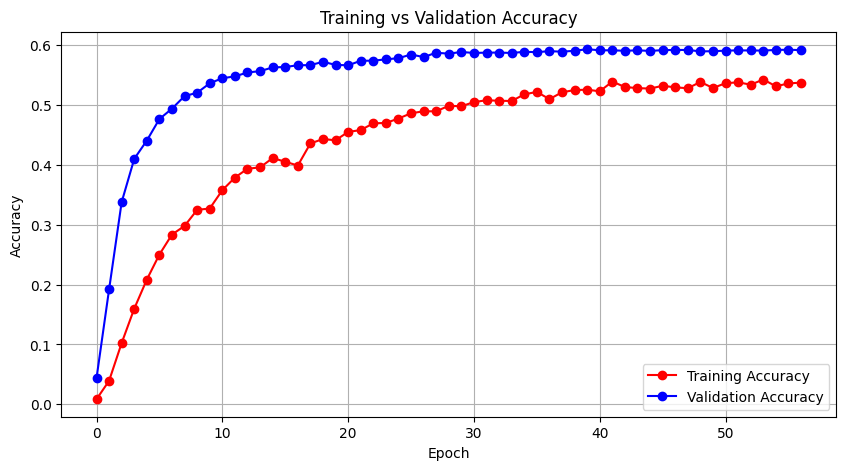

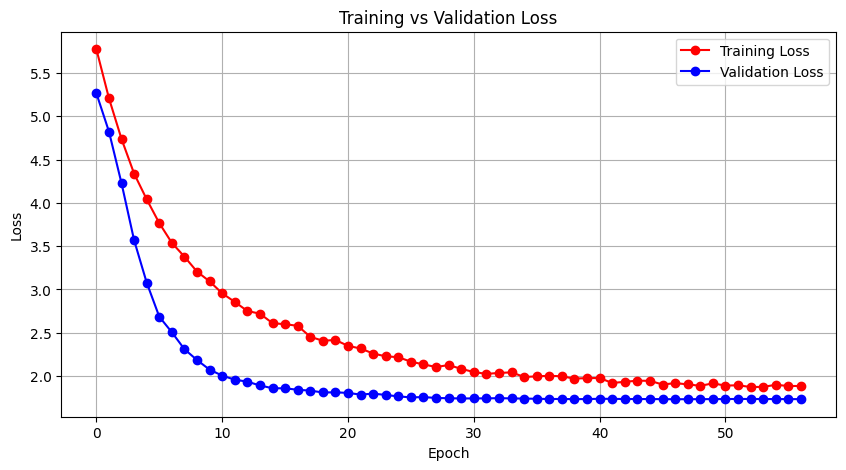

In [ ]:
import matplotlib.pyplot as plt
accuracy = history4.history['accuracy']
loss = history4.history['loss']

plt.figure(figsize=(10, 5))
plt.plot(accuracy, label='Training Accuracy', marker='o', color='red')
plt.plot(history4.history['val_accuracy'], marker='o', color='blue', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss', marker='o', color='red')
plt.plot(history4.history['val_loss'], marker='o', color='blue', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
final_model.save("/kaggle/working/mymodel_aug2.keras")  # Salvataggio nel formato nativo di Keras

In [ ]:
from tensorflow.keras.models import load_model

final_model = load_model("/kaggle/working/mymodel_aug2.keras")  

In [13]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Ottenere le predizioni
predictions = final_model.predict(val_ds)

# 2. Convertire le predizioni in classi (indice della classe con probabilità massima)
predicted_classes = np.argmax(predictions, axis=1)

# 3. Estrarre le label reali (da val_ds)
true_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in val_ds])

# 4. Calcolare l'accuracy
accuracy_val = accuracy_score(true_labels, predicted_classes)

print(f'Validation Accuracy: {accuracy_val:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 49s 371ms/step
Validation Accuracy: 0.5915


In [15]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Ottenere le predizioni
predictions = final_model.predict(test_ds)

# 2. Convertire le predizioni in classi (indice della classe con probabilità massima)
predicted_classes = np.argmax(predictions, axis=1)

# 3. Estrarre le label reali (da val_ds)
true_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in test_ds])

# 4. Calcolare l'accuracy
accuracy_test = accuracy_score(true_labels, predicted_classes)

print(f'Test Accuracy: {accuracy_test:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 279ms/step
Test Accuracy: 0.4163


In [5]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Ottenere le predizioni
predictions = final_model.predict(test_enhanched_ds)

# 2. Convertire le predizioni in classi (indice della classe con probabilità massima)
predicted_classes = np.argmax(predictions, axis=1)

# 3. Estrarre le label reali
true_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in test_enhanched_ds])

# 4. Calcolare l'accuracy
accuracy_enhanced = accuracy_score(true_labels, predicted_classes)

print(f'Test Enhanced Accuracy: {accuracy_enhanced:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 94s 673ms/step
Test Enhanced Accuracy: 0.4041


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_classes)

print(report)

              precision    recall  f1-score   support

           0       0.89      0.76      0.82        55
           1       0.66      0.57      0.61        61
           2       0.22      0.25      0.23        48
           3       0.55      0.49      0.52        47
           4       0.53      0.69      0.60        36
           5       0.38      0.33      0.35        46
           6       0.31      0.43      0.36        42
           7       0.30      0.50      0.38        40
           8       0.47      0.67      0.55        51
           9       0.21      0.42      0.28        45
          10       0.51      0.38      0.43        48
          11       0.17      0.17      0.17        36
          12       0.60      0.51      0.55        35
          13       0.31      0.34      0.32        47
          14       0.64      0.49      0.56        55
          15       0.65      0.57      0.61        60
          16       0.60      0.39      0.47        54
          17       0.68    

In [17]:
df_results = pd.DataFrame({
    "True Label": true_labels,
    "Predicted Label": predicted_classes
})
df_results.head()

,True Label,Predicted Label
0,0,51
1,0,0
2,0,95
3,0,0
4,0,42


In [12]:
df_results.to_csv("/kaggle/working/classification_results_aug_gaussian.csv", index=False)

Il rumore gaussiano peggiora anche sul degraded, possiamo provare senza contrasto e senza rumore e vediamo

In [ ]:
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2

data_dir = pathlib.Path('/kaggle/input/clean-train-no-outliers')

batch_size = 128
image_size = (224, 224)

# Creazione dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

# Definizione delle Data Augmentation
augmentation_layer = keras.Sequential([
    layers.RandomFlip("horizontal and vertical"),
    layers.RandomRotation(0.2),  # Rotazione fino a 45 gradi
    layers.Rescaling(1.0 / 255)  # Normalizzazione
])

def augment(image, label):
    return augmentation_layer(image), label

# Applicazione della data augmentation
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

print("Dataset con Data Augmentation pronto.")

Found 4883 files belonging to 251 classes.
Dataset con Data Augmentation pronto.


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation

def custom_layer_wrapper(layer_class):
    def wrapper(*args, **kwargs):
        if 'name' in kwargs:
            kwargs['name'] = kwargs['name'].replace('/', '_')  # Sostituisce "/" con "_"
        return layer_class(*args, **kwargs)
    return wrapper

custom_conv2d = custom_layer_wrapper(Conv2D)
custom_batch_norm = custom_layer_wrapper(BatchNormalization)
custom_activation = custom_layer_wrapper(Activation)

model_path = '/kaggle/input/resnet_kaggle1/other/default/1/RESNET_Kaggle.hdf5'

resnet_kaggle_model = tf.keras.models.load_model(
    model_path,
    custom_objects={
        'Conv2D': custom_conv2d,
        'BatchNormalization': custom_batch_norm,
        'Activation': custom_activation
    }
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Resizing, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
input_layer = Input(shape=(224, 224, 3))

resnet_kaggle_model.trainable = False

output_layer = resnet_kaggle_model.get_layer("global_average_pooling2d").output
intermediate_model = Model(inputs=resnet_kaggle_model.input, outputs=output_layer)

x = intermediate_model(input_layer)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

output = Dense(251, activation='softmax')(x)

final_model = Model(inputs=input_layer, outputs=output)
optimizer = Adam(learning_rate=0.001)
final_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

final_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 1920)                │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         983,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 251)                 │          32,379 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,505,723 (74.41 MB)

 Trainable params: 1,181,947 (4.51 MB)

 Non-trainable params: 18,323,776 (69.90 MB)

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history4 = final_model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    verbose=1,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.0060 - loss: 5.8978 - val_accuracy: 0.0364 - val_loss: 5.2532 - learning_rate: 0.0010
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 888ms/step - accuracy: 0.0455 - loss: 5.1213 - val_accuracy: 0.2077 - val_loss: 4.7178 - learning_rate: 0.0010
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 888ms/step - accuracy: 0.1242 - loss: 4.5751 - val_accuracy: 0.3742 - val_loss: 3.9572 - learning_rate: 0.0010
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 890ms/step - accuracy: 0.2144 - loss: 4.0780 - val_accuracy: 0.4368 - val_loss: 3.3021 - learning_rate: 0.0010
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 880ms/step - accuracy: 0.2706 - loss: 3.7104 - val_accuracy: 0.4867 - val_loss: 2.7535 - learning_rate: 0.0010
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 880ms/step - accuracy: 0.3236 - loss: 3.4425 - val_accuracy: 0.5177 - val_loss: 2.4402 - learning_rate: 0.0010
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 878ms/step - accuracy: 0.3818 - los

a

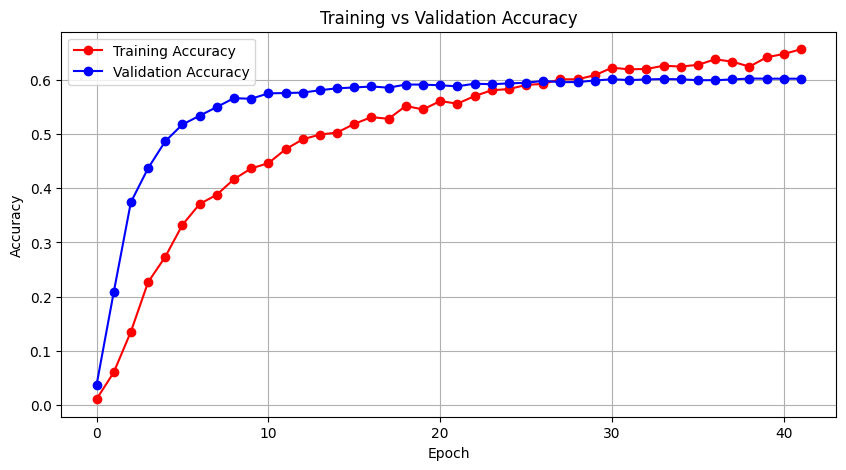

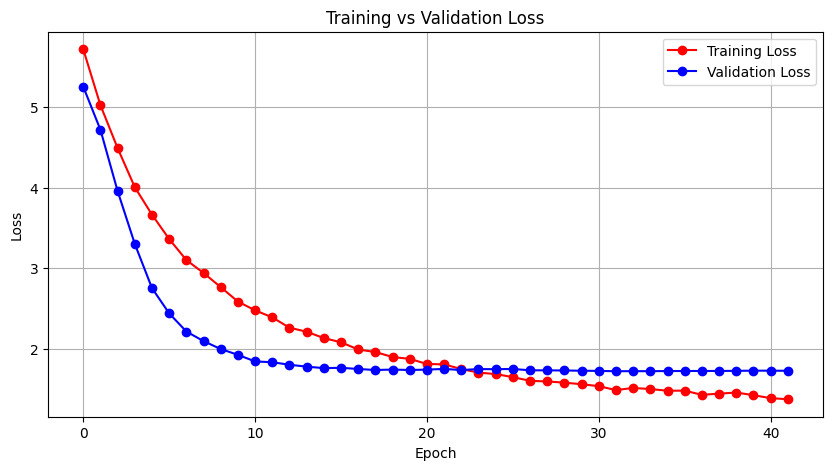

In [ ]:
import matplotlib.pyplot as plt
accuracy = history4.history['accuracy']
loss = history4.history['loss']

plt.figure(figsize=(10, 5))
plt.plot(accuracy, label='Training Accuracy', marker='o', color='red')
plt.plot(history4.history['val_accuracy'], marker='o', color='blue', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss', marker='o', color='red')
plt.plot(history4.history['val_loss'], marker='o', color='blue', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
final_model.save("/kaggle/working/mymodel_aug3.keras")  # Salvataggio nel formato nativo di Keras

In [ ]:
from tensorflow.keras.models import load_model

final_model = load_model("/kaggle/working/mymodel_aug3.keras")  

In [9]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Ottenere le predizioni
predictions = final_model.predict(val_ds)

# 2. Convertire le predizioni in classi (indice della classe con probabilità massima)
predicted_classes_validation = np.argmax(predictions, axis=1)

# 3. Estrarre le label reali (da val_ds)
validation_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in val_ds])

# 4. Calcolare l'accuracy
accuracy_val = accuracy_score(validation_labels, predicted_classes_validation)

print(f'Validation Accuracy: {accuracy_val:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 48s 367ms/step
Validation Accuracy: 0.5996


In [11]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Ottenere le predizioni
predictions = final_model.predict(test_ds)

# 2. Convertire le predizioni in classi (indice della classe con probabilità massima)
predicted_classes = np.argmax(predictions, axis=1)

# 3. Estrarre le label reali (da val_ds)
true_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in test_ds])

# 4. Calcolare l'accuracy
accuracy_test = accuracy_score(true_labels, predicted_classes)

print(f'Test Accuracy: {accuracy_test:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 278ms/step
Test Accuracy: 0.4194


In [5]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Ottenere le predizioni
predictions = final_model.predict(test_enhanched_ds)

# 2. Convertire le predizioni in classi (indice della classe con probabilità massima)
predicted_classes = np.argmax(predictions, axis=1)

# 3. Estrarre le label reali
true_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in test_enhanched_ds])

# 4. Calcolare l'accuracy
accuracy_enhanced = accuracy_score(true_labels, predicted_classes)

print(f'Test Enhanced Accuracy: {accuracy_enhanced:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 93s 673ms/step
Test Enhanced Accuracy: 0.4076


## Facciamo un dataset con il modello migliore, ovvero il primo augumentato

In [5]:
import os
import pathlib
import zipfile
import tensorflow as tf
import pandas as pd
import numpy as np

In [ ]:
from tensorflow.keras.models import load_model

final_model = load_model("/kaggle/input/mymodel_aug1/other/default/1/mymodel_aug (1).keras")  

In [3]:
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [ ]:
val_data_dir = pathlib.Path('/kaggle/input/val-set-class/val_set_class')

# Creazione del dataset di addestramento
batch_size = 128
image_size = (224, 224)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    seed=42
)
val_ds = val_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
print("Val dataset ready.")

Found 11994 files belonging to 251 classes.
Val dataset ready.


In [ ]:
import pandas as pd
import numpy as np
import gc
import pathlib
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score

def get_image_filenames(dataset, base_path):
    file_paths = list(base_path.glob("**/*.jpg"))  # Cambia *.jpg se usi PNG
    file_paths.sort()  # 🔥 Assicura che siano in ordine
    return [str(path).split("/")[-1] for path in file_paths]

val_image_names = get_image_filenames(val_ds, pathlib.Path('/kaggle/input/val-set-class/val_set_class'))

val_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in val_ds])

if len(val_image_names) != len(val_labels):
    raise ValueError(f"Errore: numero di immagini ({len(val_image_names)}) e etichette ({len(val_labels)}) non corrisponde!")

print("Eseguendo predizione per dataset Original...")
predicted_classes_val = final_model.predict(val_ds)
predicted_classes_val = np.argmax(predicted_classes_val, axis=1)

unique_classes = sorted(set(val_labels))

accuracy_per_class = [
    accuracy_score(val_labels[val_labels == cls], predicted_classes_val[val_labels == cls]) 
    for cls in tqdm(unique_classes, desc="Calcolando Accuracy")
]

precision_per_class = precision_score(val_labels, predicted_classes_val, average=None)

tuples_per_class = []
for cls in unique_classes:
    class_indices = np.where(val_labels == cls)[0]  # Trova gli indici delle immagini di questa classe
    class_tuples = [(predicted_classes_val[i], val_image_names[i]) for i in class_indices]
    tuples_per_class.append(class_tuples)

df_original = pd.DataFrame({
    "Class_Target": unique_classes,
    "Accuracy_": accuracy_per_class,
    "Precision_": precision_per_class,
    "Tuple(Class_Predicted, Image_Name)": tuples_per_class
})

df_original.to_csv("/kaggle/working/classification_metrics_original.csv", index=False)

del predicted_classes_val
gc.collect()

print("✅ CSV salvato per il dataset Original con corrispondenza immagini-etichetta verificata!")


Eseguendo predizione per dataset Original...
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step


Calcolando Accuracy: 100%|██████████| 251/251 [00:00<00:00, 3234.60it/s]


✅ CSV salvato per il dataset Original con corrispondenza immagini-etichetta verificata!


In [11]:
df_original.head()

,Class_Target,Accuracy_,Precision_,"Tuple(Class_Predicted, Image_Name)"
0,0,0.854545,0.959184,"[(239, val_000013.jpg), (0, val_000078.jpg), (..."
1,1,0.836066,0.850000,"[(1, val_000080.jpg), (136, val_000173.jpg), (..."
2,2,0.520833,0.555556,"[(190, val_000037.jpg), (80, val_000257.jpg), ..."
3,3,0.808511,0.703704,"[(3, val_000605.jpg), (3, val_000728.jpg), (3,..."
4,4,0.777778,0.903226,"[(13, val_000493.jpg), (4, val_000596.jpg), (4..."


In [ ]:
test_data_dir = pathlib.Path('/kaggle/input/val-set-degraded-class/val_set_degraded_class')

batch_size = 128
image_size = (224, 224)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    seed=42
)
test_ds = test_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
print("Test dataset ready.")

Found 11994 files belonging to 251 classes.
Test dataset ready.


In [ ]:
import pandas as pd
import numpy as np
import gc
import pathlib
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score

def get_image_filenames(dataset, base_path):
    file_paths = list(base_path.glob("**/*.jpg"))  # Cambia *.jpg se usi PNG
    file_paths.sort()  # 🔥 Assicura che siano in ordine
    return [str(path).split("/")[-1] for path in file_paths]

test_image_names = get_image_filenames(test_ds, pathlib.Path('/kaggle/input/val-set-degraded-class/val_set_degraded_class'))

test_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in test_ds])

if len(test_image_names) != len(test_labels):
    raise ValueError(f"Errore: numero di immagini ({len(test_image_names)}) e etichette ({len(test_labels)}) non corrisponde!")

print("Eseguendo predizione per dataset Degraded...")
predicted_classes_test = final_model.predict(test_ds)
predicted_classes_test = np.argmax(predicted_classes_test, axis=1)

unique_classes = sorted(set(test_labels))

accuracy_per_class = [
    accuracy_score(test_labels[test_labels == cls], predicted_classes_test[test_labels == cls]) 
    for cls in tqdm(unique_classes, desc="Calcolando Accuracy")
]

precision_per_class = precision_score(test_labels, predicted_classes_test, average
tuples_per_class = []
for cls in unique_classes:
    class_indices = np.where(test_labels == cls)[0]  # Trova gli indici delle immagini di questa classe
    class_tuples = [(predicted_classes_test[i], test_image_names[i]) for i in class_indices]
    tuples_per_class.append(class_tuples)

df_degraded = pd.DataFrame({
    "Class_Target": unique_classes,
    "Accuracy_": accuracy_per_class,
    "Precision_": precision_per_class,
    "Tuple(Class_Predicted, Image_Name)": tuples_per_class
})

df_degraded.to_csv("/kaggle/working/classification_metrics_degraded.csv", index=False)

del predicted_classes_test
gc.collect()

print("✅ CSV salvato per il dataset Degraded con corrispondenza immagini-etichetta verificata!")


Eseguendo predizione per dataset Degraded...
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step


Calcolando Accuracy: 100%|██████████| 251/251 [00:00<00:00, 3357.85it/s]


✅ CSV salvato per il dataset Degraded con corrispondenza immagini-etichetta verificata!


In [14]:
df_degraded.head()

,Class_Target,Accuracy_,Precision_,"Tuple(Class_Predicted, Image_Name)"
0,0,0.600000,0.785714,"[(113, val_000013.jpg), (0, val_000078.jpg), (..."
1,1,0.508197,0.775000,"[(1, val_000080.jpg), (155, val_000173.jpg), (..."
2,2,0.291667,0.233333,"[(190, val_000037.jpg), (204, val_000257.jpg),..."
3,3,0.617021,0.446154,"[(140, val_000605.jpg), (3, val_000728.jpg), (..."
4,4,0.666667,0.244898,"[(13, val_000493.jpg), (4, val_000596.jpg), (4..."


In [ ]:
test_data_dir = pathlib.Path('/kaggle/input/val-set-enhanced')

batch_size = 128
image_size = (224, 224)

test_enhanched_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    seed=42
)
test_enhanched_ds = test_enhanched_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
test_enhanched_ds = test_enhanched_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
print("Test enhanced dataset ready.")

Found 11994 files belonging to 251 classes.
Test enhanced dataset ready.


In [ ]:
import pandas as pd
import numpy as np
import gc
import pathlib
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score

def get_image_filenames_with_labels(base_path):
    """Legge tutte le immagini dalla cartella e assegna la classe target basandosi sulla struttura delle cartelle."""
    image_paths = list(base_path.glob("*/*.jpg"))  # Cambia *.jpg se usi PNG
    image_data = [(int(path.parent.name), str(path).split("/")[-1]) for path in image_paths]  # (Classe_Target, Nome Immagine)
    image_data.sort(key=lambda x: x[1])  # Assicura che siano ordinate
    return image_data

base_path = pathlib.Path('/kaggle/input/val-set-enhanced')
test_enhanced_data = get_image_filenames_with_labels(base_path)

test_enhanced_labels, test_enhanced_image_names = zip(*test_enhanced_data)

test_enhanced_labels = np.array(test_enhanced_labels)
test_enhanced_image_names = np.array(test_enhanced_image_names)

print("Eseguendo predizione per dataset Enhanced...")
predicted_classes_test_enh = final_model.predict(test_enhanched_ds)
predicted_classes_test_enh = np.argmax(predicted_classes_test_enh, axis=1)

image_data = list(zip(test_enhanced_labels, predicted_classes_test_enh, test_enhanced_image_names))

class_dict = {cls: [] for cls in sorted(set(test_enhanced_labels))}

for true_label, pred_label, img_name in image_data:
    class_dict[true_label].append((pred_label, img_name))  # Associa la previsione e il nome alla classe target

df_enhanced = pd.DataFrame({
    "Class_Target": list(class_dict.keys()),
    "Tuple(Class_Predicted, Image_Name)": list(class_dict.values())
})

df_enhanced["Accuracy_"] = df_enhanced["Class_Target"].apply(
    lambda cls: accuracy_score(
        [true for true, pred, img in image_data if true == cls], 
        [pred for true, pred, img in image_data if true == cls]
    )
)

df_enhanced["Precision_"] = df_enhanced["Class_Target"].apply(
    lambda cls: precision_score(
        test_enhanced_labels, predicted_classes_test_enh, average=None
    )[cls]
)

df_enhanced.to_csv("/kaggle/working/classification_metrics_enhanced.csv", index=False)

del predicted_classes_test_enh
gc.collect()

print("✅ CSV salvato per il dataset Enhanced con classi target corrette dalla struttura delle cartelle!")


Eseguendo predizione per dataset Enhanced...
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step
✅ CSV salvato per il dataset Enhanced con classi target corrette dalla struttura delle cartelle!


In [ ]:
df_enhanced.head()
df_enhanced.to_csv("/kaggle/working/classification_metrics_enhanced1.csv", index=False)

In [ ]:
import pandas as pd

path_original = "/kaggle/working/classification_metrics_original.csv"
path_degraded = "/kaggle/working/classification_metrics_degraded.csv"
path_enhanced = "/kaggle/working/classification_metrics_enhanced.csv"

# Caricamento dei dataset
df_original = pd.read_csv(path_original)
df_degraded = pd.read_csv(path_degraded)
df_enhanced = pd.read_csv(path_enhanced)

df_original = df_original.rename(columns={
    "Accuracy_": "Accuracy_Original",
    "Precision_": "Precision_Original",
    "Tuple(Class_Predicted, Image_Name)": "Tuple_Original"
})

df_degraded = df_degraded.rename(columns={
    "Accuracy_": "Accuracy_Degraded",
    "Precision_": "Precision_Degraded",
    "Tuple(Class_Predicted, Image_Name)": "Tuple_Degraded"
})

df_enhanced = df_enhanced.rename(columns={
    "Accuracy_": "Accuracy_Enhanced",
    "Precision_": "Precision_Enhanced",
    "Tuple(Class_Predicted, Image_Name)": "Tuple_Enhanced"
})

df_metrics = df_original.merge(df_degraded, on="Class_Target").merge(df_enhanced, on="Class_Target")

df_metrics.to_csv("/kaggle/working/classification_metrics_cabasoel.csv", index=False)


print("✅ File unificato salvato come classification_metrics_merged.csv!")

✅ File unificato salvato come classification_metrics_merged.csv!


In [8]:
df_metrics.sort_values(by="Accuracy_Original", ascending=True)

,Class_Target,Accuracy_Original,Precision_Original,Tuple_Original,Accuracy_Degraded,Precision_Degraded,Tuple_Degraded,Accuracy_Enhanced,Precision_Enhanced,Tuple_Enhanced
213,213,0.041667,0.055556,"[(205, 'val_000457.jpg'), (100, 'val_001524.jp...",0.000000,0.000000,"[(205, 'val_000457.jpg'), (197, 'val_001524.jp...",0.125000,0.096774,"[(5, 'val_000457.jpg'), (212, 'val_001524.jpg'..."
161,161,0.055556,0.181818,"[(161, 'val_010329.jpg'), (104, 'val_010330.jp...",0.027778,0.111111,"[(161, 'val_010329.jpg'), (104, 'val_010330.jp...",0.000000,0.000000,"[(130, 'val_010329.jpg'), (102, 'val_010330.jp..."
25,25,0.083333,0.130435,"[(44, 'val_000345.jpg'), (134, 'val_000374.jpg...",0.083333,0.107143,"[(44, 'val_000345.jpg'), (134, 'val_000374.jpg...",0.055556,0.037736,"[(197, 'val_000345.jpg'), (134, 'val_000374.jp..."
155,155,0.090909,0.166667,"[(155, 'val_010581.jpg'), (95, 'val_010685.jpg...",0.090909,0.018182,"[(215, 'val_010581.jpg'), (160, 'val_010685.jp...",0.090909,0.100000,"[(190, 'val_010581.jpg'), (165, 'val_010685.jp..."
234,234,0.100000,0.266667,"[(245, 'val_000094.jpg'), (87, 'val_000158.jpg...",0.075000,0.093750,"[(245, 'val_000094.jpg'), (97, 'val_000158.jpg...",0.150000,0.136364,"[(245, 'val_000094.jpg'), (41, 'val_000158.jpg..."
...,...,...,...,...,...,...,...,...,...,...
110,110,0.875000,0.660377,"[(189, 'val_000128.jpg'), (110, 'val_000242.jp...",0.500000,0.606061,"[(189, 'val_000128.jpg'), (145, 'val_000242.jp...",0.375000,0.517241,"[(189, 'val_000128.jpg'), (116, 'val_000242.jp..."
170,170,0.877193,0.632911,"[(170, 'val_000760.jpg'), (170, 'val_000915.jp...",0.561404,0.640000,"[(3, 'val_000760.jpg'), (56, 'val_000915.jpg')...",0.631579,0.571429,"[(170, 'val_000760.jpg'), (149, 'val_000915.jp..."
185,185,0.878049,0.590164,"[(185, 'val_000292.jpg'), (185, 'val_000710.jp...",0.756098,0.413333,"[(186, 'val_000292.jpg'), (185, 'val_000710.jp...",0.804878,0.397590,"[(153, 'val_000292.jpg'), (185, 'val_000710.jp..."
83,83,0.886792,0.854545,"[(83, 'val_000583.jpg'), (19, 'val_000887.jpg'...",0.622642,0.846154,"[(83, 'val_000583.jpg'), (35, 'val_000887.jpg'...",0.698113,0.587302,"[(83, 'val_000583.jpg'), (19, 'val_000887.jpg'..."


In [12]:
df_metrics['Accuracy_Enhanced'].describe()

count    251.000000
mean       0.404133
std        0.171929
min        0.000000
25%        0.285714
50%        0.403846
75%        0.518188
max        0.863636
Name: Accuracy_Enhanced, dtype: float64

In [7]:
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Ottenere le predizioni
predictions = final_model.predict(test_enhanched_ds)

# 2. Convertire le predizioni in classi (indice della classe con probabilità massima)
predicted_classes = np.argmax(predictions, axis=1)

# 3. Estrarre le label reali
true_labels = np.concatenate([y.numpy().argmax(axis=1) for x, y in test_enhanched_ds])

# 4. Calcolare l'accuracy
accuracy_enhanced = accuracy_score(true_labels, predicted_classes)

print(f'Test Enhanced Accuracy: {accuracy_enhanced:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 95s 686ms/step
Test Enhanced Accuracy: 0.4145


In [8]:
from sklearn.metrics import classification_report

# Genera il report di classificazione senza target_names (se le classi sono numeriche)
report = classification_report(true_labels, predicted_classes)

# Stampa il report
print(report)

              precision    recall  f1-score   support

           0       0.88      0.67      0.76        55
           1       0.76      0.52      0.62        61
           2       0.30      0.35      0.33        48
           3       0.44      0.57      0.50        47
           4       0.47      0.69      0.56        36
           5       0.40      0.35      0.37        46
           6       0.29      0.45      0.35        42
           7       0.29      0.47      0.36        40
           8       0.55      0.67      0.60        51
           9       0.33      0.49      0.39        45
          10       0.38      0.29      0.33        48
          11       0.27      0.22      0.24        36
          12       0.34      0.46      0.39        35
          13       0.44      0.36      0.40        47
          14       0.57      0.60      0.58        55
          15       0.62      0.55      0.58        60
          16       0.48      0.39      0.43        54
          17       0.56    